# Preparación

In [4]:
from pyspark.sql import functions as F
from ETL_pg2neo4j.diagnostics import get_machine_stats
from ETL_pg2neo4j.spark_session import get_spark
from ETL_pg2neo4j.load_config import (
    NEO4J_URI, NEO4J_USER, NEO4J_PASS, NEO4J_DDBB
)

stats = get_machine_stats()
spark, jdbc_props = get_spark(stats)

opts = { #Alternativa a cargar desde la sesión de spark
    "url": NEO4J_URI,
    "authentication.type": "basic",
    "authentication.basic.username": NEO4J_USER,
    "authentication.basic.password": NEO4J_PASS,
    "database": NEO4J_DDBB  
}

[SPARK] usando jars locales -> /opt/spark/extra-jars/postgresql-42.7.4.jar,/opt/spark/extra-jars/neo4j-connector-apache-spark_2.12-5.3.10_for_spark_3.jar
[SPARK] classpath reforzado (driver/executors) -> /opt/spark/extra-jars/postgresql-42.7.4.jar:/opt/spark/extra-jars/neo4j-connector-apache-spark_2.12-5.3.10_for_spark_3.jar


ERROR StatusLogger Reconfiguration failed: No configuration found for '5ffd2b27' at 'null' in 'null'
ERROR StatusLogger Reconfiguration failed: No configuration found for 'Default' at 'null' in 'null'
25/11/27 15:50:25 WARN Utils: Your hostname, AsusMare resolves to a loopback address: 127.0.1.1; using 192.168.100.4 instead (on interface wlp2s0)
25/11/27 15:50:25 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
25/11/27 15:50:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/27 15:50:27 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


[CHECK] Postgres JDBC REALMENTE visible
[CHECK] Neo4j connector REALMENTE visible


In [5]:
# Query Cypher para nodos: trae solo lo que te interesa ahora
node_query = """
MATCH (a:Account)
RETURN
    id(a)                  AS neo4j_id,
    a.account_number       AS account_number,
    a.location             AS location,
    a.current_balance      AS current_balance,
    a.first_seen           AS first_seen,
    a.last_seen            AS last_seen
"""

nodes_df = (
    spark.read
        .format("org.neo4j.spark.DataSource")
        .option("url", NEO4J_URI)
        .option("authentication.type", "basic")
        .option("authentication.basic.username", NEO4J_USER)
        .option("authentication.basic.password", NEO4J_PASS)
        .option("database", NEO4J_DDBB)
        .option("query", node_query)
        .load()
)

nodes_df.printSchema()
nodes_df.limit(5).toPandas()


root
 |-- neo4j_id: long (nullable = true)
 |-- account_number: long (nullable = true)
 |-- location: string (nullable = true)
 |-- current_balance: double (nullable = true)
 |-- first_seen: timestamp (nullable = true)
 |-- last_seen: timestamp (nullable = true)



/home/felpipe/1 - UDD/Bank fraud detection/KaggleChallenges/venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
                                                                                

,neo4j_id,account_number,location,current_balance,first_seen,last_seen
0,0,4651102136,UK,51445.62,2023-03-17 21:35:31,2023-03-18 18:45:28
1,1,3647155427,UK,-68020.94,2023-03-10 06:34:09,2023-03-10 20:02:05
2,2,8986636663,UK,2804.26,2022-10-27 06:16:50,2023-05-20 08:41:51
3,3,196361780,UK,131638.48,2022-10-17 16:03:31,2023-07-07 13:12:55
4,4,3775525103,UK,15667.70,2022-11-06 08:09:43,2023-07-23 11:39:54


In [6]:
edge_query = """
MATCH (src:Account)-[r:TX]->(dst:Account)
RETURN
    id(r)                        AS neo4j_rel_id,
    r.id                         AS id,
    src.account_number           AS src,
    dst.account_number           AS dst,
    r.timestamp                  AS timestamp,
    r.amount                     AS amount,
    r.payment_currency           AS payment_currency,
    r.received_currency          AS received_currency,
    r.payment_type               AS payment_type,
    r.is_laundering              AS is_laundering,
    r.laundering_type            AS laundering_type,
    r.masked                     AS masked,
    r.src_delta                  AS src_delta,
    r.src_balance_before         AS src_balance_before,
    r.src_balance_after          AS src_balance_after,
    r.src_seq                    AS src_seq,
    r.src_currency               AS src_currency,
    r.dst_delta                  AS dst_delta,
    r.dst_balance_before         AS dst_balance_before,
    r.dst_balance_after          AS dst_balance_after,
    r.dst_seq                    AS dst_seq,
    r.dst_currency               AS dst_currency
"""

edges_df = (
    spark.read
        .format("org.neo4j.spark.DataSource")
        .option("url", NEO4J_URI)
        .option("authentication.type", "basic")
        .option("authentication.basic.username", NEO4J_USER)
        .option("authentication.basic.password", NEO4J_PASS)
        .option("database", NEO4J_DDBB)
        .option("query", edge_query)
        .load()
)

edges_df.printSchema()
edges_df.limit(5).toPandas()


root
 |-- neo4j_rel_id: long (nullable = true)
 |-- id: long (nullable = true)
 |-- src: long (nullable = true)
 |-- dst: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- amount: double (nullable = true)
 |-- payment_currency: string (nullable = true)
 |-- received_currency: string (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- is_laundering: long (nullable = true)
 |-- laundering_type: string (nullable = true)
 |-- masked: long (nullable = true)
 |-- src_delta: double (nullable = true)
 |-- src_balance_before: double (nullable = true)
 |-- src_balance_after: double (nullable = true)
 |-- src_seq: long (nullable = true)
 |-- src_currency: string (nullable = true)
 |-- dst_delta: double (nullable = true)
 |-- dst_balance_before: double (nullable = true)
 |-- dst_balance_after: double (nullable = true)
 |-- dst_seq: long (nullable = true)
 |-- dst_currency: string (nullable = true)



/home/felpipe/1 - UDD/Bank fraud detection/KaggleChallenges/venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


,neo4j_rel_id,id,src,dst,timestamp,amount,payment_currency,received_currency,payment_type,is_laundering,...,src_delta,src_balance_before,src_balance_after,src_seq,src_currency,dst_delta,dst_balance_before,dst_balance_after,dst_seq,dst_currency
0,1152921504606846977,244716,3647155427,9621415000,2023-03-10 09:27:35,5690.77,UK pounds,UK pounds,Cheque,0,...,-5690.77,-5679.90,-11370.67,2,UK pounds,5690.77,-2606349.39,-2600658.62,419,UK pounds
1,1155173304420532225,249074,3647155427,9621415000,2023-03-10 15:01:57,5675.27,UK pounds,UK pounds,Credit card,0,...,-5675.27,-39688.01,-45363.28,8,UK pounds,5675.27,-1725124.81,-1719449.54,490,UK pounds
2,1157425104234217473,870245,3647155427,9621415000,2023-03-10 09:33:58,5646.99,UK pounds,UK pounds,Debit card,0,...,-5646.99,-11370.67,-17017.66,3,UK pounds,5646.99,-2585985.23,-2580338.24,422,UK pounds
3,1159676904047902721,1465965,3647155427,9621415000,2023-03-10 14:08:04,5580.07,UK pounds,UK pounds,Cheque,0,...,-5580.07,-28389.75,-33969.82,6,UK pounds,5580.07,-1889191.02,-1883610.95,477,UK pounds
4,1161928703861587969,2765964,3647155427,9621415000,2023-03-10 18:02:32,5677.54,UK pounds,UK pounds,Credit card,0,...,-5677.54,-51048.20,-56725.74,10,UK pounds,5677.54,-1316931.57,-1311254.03,525,UK pounds


# Grados y hubs

## Métricas básicas por nodo

In [5]:
# --- OUT: métricas como emisor (src) ---
out_stats = (
    edges_df
    .groupBy("src")
    .agg(
        F.count("*").alias("out_degree"),
        F.sum("amount").alias("out_amount_sum"),
        F.sum("is_laundering").alias("fraud_out_count")  # is_laundering es 0/1
    )
)

# --- IN: métricas como receptor (dst) ---
in_stats = (
    edges_df
    .groupBy("dst")
    .agg(
        F.count("*").alias("in_degree"),
        F.sum("amount").alias("in_amount_sum"),
        F.sum("is_laundering").alias("fraud_in_count")
    )
)


In [6]:
# Partimos de los atributos "básicos" que sí nos interesan
base_nodes = nodes_df.select(
    "account_number",
    "location",
    "current_balance",
    "first_seen",
    "last_seen"
)

node_metrics_df = (
    base_nodes
    # join con estadísticas de salida
    .join(out_stats, base_nodes.account_number == out_stats.src, "left")
    # join con estadísticas de entrada
    .join(in_stats, base_nodes.account_number == in_stats.dst, "left")
    .drop("src", "dst")
)

# Rellenar los nulls (cuentas que nunca emitieron/recibieron algo) con 0
numeric_cols = [
    "out_degree", "out_amount_sum", "fraud_out_count",
    "in_degree", "in_amount_sum", "fraud_in_count"
]

for c in numeric_cols:
    node_metrics_df = node_metrics_df.withColumn(
        c, F.coalesce(F.col(c), F.lit(0.0))
    )

# Cast a tipos más "bonitos" donde toque (los counts como long/int)
node_metrics_df = (
    node_metrics_df
    .withColumn("out_degree", F.col("out_degree").cast("long"))
    .withColumn("in_degree", F.col("in_degree").cast("long"))
    .withColumn("fraud_out_count", F.col("fraud_out_count").cast("long"))
    .withColumn("fraud_in_count", F.col("fraud_in_count").cast("long"))
)


In [7]:
node_metrics_df = (
    node_metrics_df
    .withColumn(
        "fraud_out_ratio",
        F.when(F.col("out_degree") > 0,
               F.col("fraud_out_count") / F.col("out_degree"))
         .otherwise(F.lit(0.0))
    )
    .withColumn(
        "fraud_in_ratio",
        F.when(F.col("in_degree") > 0,
               F.col("fraud_in_count") / F.col("in_degree"))
         .otherwise(F.lit(0.0))
    )
)


## Vecinos y vecinos fraudulentos

In [8]:
#Vecinos totales
# Aristas no dirigidas (a,b) y (b,a), sin duplicados
edges_undirected = (
    edges_df
    .select(F.col("src").alias("a"), F.col("dst").alias("b"))
    .unionByName(
        edges_df.select(F.col("dst").alias("a"), F.col("src").alias("b"))
    )
    .dropDuplicates()
)

neighbors = (
    edges_undirected
    .groupBy("a")
    .agg(F.countDistinct("b").alias("neighbors_count"))
)


In [9]:
#Vecinos con al menos un enlace fraudulento
fraud_edges_undirected = (
    edges_df
    .filter(F.col("is_laundering") == 1)
    .select(F.col("src").alias("a"), F.col("dst").alias("b"))
    .unionByName(
        edges_df
        .filter(F.col("is_laundering") == 1)
        .select(F.col("dst").alias("a"), F.col("src").alias("b"))
    )
    .dropDuplicates()
)

fraud_neighbors = (
    fraud_edges_undirected
    .groupBy("a")
    .agg(F.countDistinct("b").alias("fraud_neighbors_count"))
)


In [10]:
node_metrics_df = (
    node_metrics_df
    .join(neighbors, node_metrics_df.account_number == neighbors.a, "left")
    .join(fraud_neighbors, node_metrics_df.account_number == fraud_neighbors.a, "left")
    .drop("a")
)

node_metrics_df = (
    node_metrics_df
    .withColumn("neighbors_count", F.coalesce(F.col("neighbors_count"), F.lit(0)))
    .withColumn("fraud_neighbors_count", F.coalesce(F.col("fraud_neighbors_count"), F.lit(0)))
    .withColumn(
        "fraud_neighbors_ratio",
        F.when(F.col("neighbors_count") > 0,
               F.col("fraud_neighbors_count") / F.col("neighbors_count"))
         .otherwise(F.lit(0.0))
    )
)


In [11]:
node_metrics_df.select(
    "in_degree", "out_degree",
    "in_amount_sum", "out_amount_sum",
    "fraud_in_ratio", "fraud_out_ratio",
    "neighbors_count", "fraud_neighbors_ratio"
).summary("count", "mean", "stddev", "min", "25%", "50%", "75%", "max").show(truncate=False)


25/11/26 23:30:29 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
                                                                                

+-------+------------------+------------------+------------------+-----------------+---------------------+-------------------+------------------+---------------------+
|summary|in_degree         |out_degree        |in_amount_sum     |out_amount_sum   |fraud_in_ratio       |fraud_out_ratio    |neighbors_count   |fraud_neighbors_ratio|
+-------+------------------+------------------+------------------+-----------------+---------------------+-------------------+------------------+---------------------+
|count  |855460            |855460            |855460            |855460           |855460               |855460             |855460            |855460               |
|mean   |11.110808220138873|11.110808220138873|97363.65245319254 |97363.65245319293|0.0015532081593782822|3.79021782102301E-4|1.9652116989689759|0.0018401598192986234|
|stddev |27.02063620269903 |55.75791563599599 |281141.07274827536|459051.6994912461|0.03469331988431024  |0.01035075493637477|6.494315089979579 |0.0329752019288

In [12]:
deg_dist = (
    node_metrics_df
    .withColumn(
        "out_degree_bin",
        F.when(F.col("out_degree") == 0, "0")
         .otherwise(
             F.concat(
                 F.lit("1e"),
                 F.floor(F.log10("out_degree")).cast("int")  # 1e0, 1e1, 1e2...
             )
         )
    )
    .groupBy("out_degree_bin")
    .count()
    .orderBy("out_degree_bin")
)

deg_dist.show(truncate=False)


+--------------+------+
|out_degree_bin|count |
+--------------+------+
|0             |562745|
|1e0           |75997 |
|1e1           |198174|
|1e2           |18544 |
+--------------+------+



In [13]:
def add_degree_bins(df, col_name, bin_col_name):
    return (
        df.withColumn(
            bin_col_name,
            F.when(F.col(col_name) == 0, "0")
             .when(F.col(col_name) == 1, "1")
             .when((F.col(col_name) >= 2) & (F.col(col_name) <= 5), "2–5")
             .when((F.col(col_name) >= 6) & (F.col(col_name) <= 10), "6–10")
             .when((F.col(col_name) >= 11) & (F.col(col_name) <= 20), "11–20")
             .when((F.col(col_name) >= 21) & (F.col(col_name) <= 50), "21–50")
             .when((F.col(col_name) >= 51) & (F.col(col_name) <= 100), "51–100")
             .when((F.col(col_name) >= 101) & (F.col(col_name) <= 200), "101–200")
             .otherwise(">200")
        )
    )

# Añadimos bins para in/out degree
node_binned_df = (
    node_metrics_df
    .transform(lambda df: add_degree_bins(df, "out_degree", "out_degree_bin"))
    .transform(lambda df: add_degree_bins(df, "in_degree", "in_degree_bin"))
)

# Distribución de out_degree
out_deg_dist_spark = (
    node_binned_df
    .groupBy("out_degree_bin")
    .count()
    .orderBy("out_degree_bin")
)

# Distribución de in_degree
in_deg_dist_spark = (
    node_binned_df
    .groupBy("in_degree_bin")
    .count()
    .orderBy("in_degree_bin")
)


/home/felpipe/1 - UDD/Bank fraud detection/KaggleChallenges/venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
                                                                                

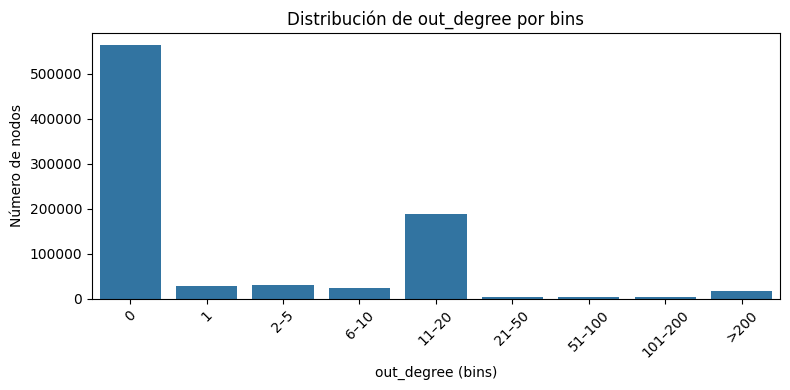

/home/felpipe/1 - UDD/Bank fraud detection/KaggleChallenges/venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
                                                                                

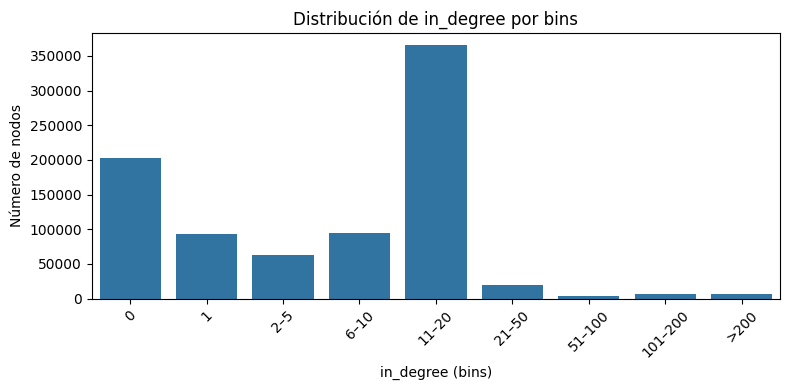

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

deg_bins_order = ["0", "1", "2–5", "6–10", "11–20", "21–50", "51–100", "101–200", ">200"]

# OUT DEGREE
out_deg_dist = out_deg_dist_spark.toPandas()
cat_type_out = pd.CategoricalDtype(categories=deg_bins_order, ordered=True)
out_deg_dist["out_degree_bin"] = out_deg_dist["out_degree_bin"].astype(cat_type_out)
out_deg_dist = out_deg_dist.sort_values("out_degree_bin")

plt.figure(figsize=(8,4))
sns.barplot(
    data=out_deg_dist,
    x="out_degree_bin",
    y="count"
)
plt.title("Distribución de out_degree por bins")
plt.xlabel("out_degree (bins)")
plt.ylabel("Número de nodos")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# IN DEGREE
in_deg_dist = in_deg_dist_spark.toPandas()
cat_type_in = pd.CategoricalDtype(categories=deg_bins_order, ordered=True)
in_deg_dist["in_degree_bin"] = in_deg_dist["in_degree_bin"].astype(cat_type_in)
in_deg_dist = in_deg_dist.sort_values("in_degree_bin")

plt.figure(figsize=(8,4))
sns.barplot(
    data=in_deg_dist,
    x="in_degree_bin",
    y="count"
)
plt.title("Distribución de in_degree por bins")
plt.xlabel("in_degree (bins)")
plt.ylabel("Número de nodos")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [15]:
# Tomar, por ejemplo, el 10% de los nodos (o un límite de filas)
sample_df = node_metrics_df.sample(withReplacement=False, fraction=0.1, seed=42)

sample_pd = sample_df.select(
    "in_degree", "out_degree",
    "in_amount_sum", "out_amount_sum",
    "fraud_in_ratio", "fraud_out_ratio",
    "neighbors_count", "fraud_neighbors_ratio"
).toPandas()

sample_pd.describe(percentiles=[0.25, 0.5, 0.75]).T  # se ve muy legible en Jupyter


/home/felpipe/1 - UDD/Bank fraud detection/KaggleChallenges/venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
                                                                                

,count,mean,std,min,25%,50%,75%,max
in_degree,85828.0,11.104814,27.028108,0.0,1.0000,9.00,13.0000,7.300000e+02
out_degree,85828.0,11.063301,55.584429,0.0,0.0000,0.00,10.0000,7.420000e+02
in_amount_sum,85828.0,98179.820361,283783.671475,0.0,942.6725,23739.39,99034.6700,1.439340e+07
out_amount_sum,85828.0,97172.025458,459192.580207,0.0,0.0000,0.00,59270.7625,1.372392e+07
fraud_in_ratio,85828.0,0.001657,0.036405,0.0,0.0000,0.00,0.0000,1.000000e+00
fraud_out_ratio,85828.0,0.000367,0.009102,0.0,0.0000,0.00,0.0000,6.666667e-01
neighbors_count,85828.0,1.960596,6.465982,1.0,1.0000,1.00,1.0000,7.600000e+01
fraud_neighbors_ratio,85828.0,0.001972,0.034782,0.0,0.0000,0.00,0.0000,1.000000e+00


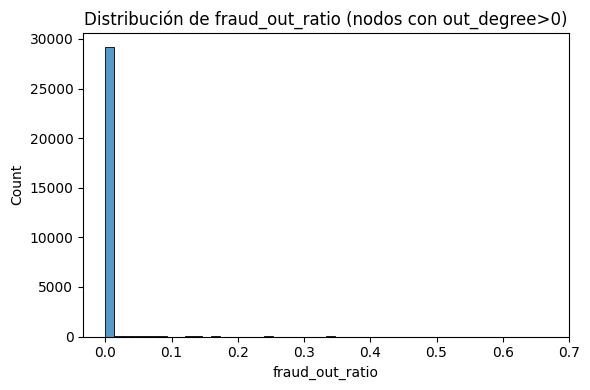

In [16]:
plt.figure(figsize=(6,4))
sns.histplot(
    data=sample_pd[sample_pd["out_degree"] > 0], 
    x="fraud_out_ratio",
    bins=50
)
plt.title("Distribución de fraud_out_ratio (nodos con out_degree>0)")
plt.tight_layout()
plt.show()

In [17]:
del edges_undirected, fraud_edges_undirected

Más de 500k cuentas con out_degree 0, nunca envían dinero. El resto se reparte en bins crecientes con solo una minoría de con out_degree alto. La moda del set es que las cuentas envíen entre 11 a 20 transferencias si es que son activas. La mayoría (moda real) no lo son.

Muchísima más masa hasta las 20 transacciones. Recibir dinero es mucho más común que enviarlo. El promedio de vecinos por nodo es de 2 por lo que la conectividad parece pequeña.

Ratios de fraude (fraud_in_ratio, fraud_out_ratio) tienen medias bajísimas, pero con colas que llegan a 1 lo que implica que hay cuentas completamente asociadas a fraude. Esto valida los hubs elegidos en el EDA temporal. Sin embargo, ese ejercicio carece de peso estadístico por la baja cantidad de hubs elegidos. Aún así, es un buen ejercicio, pues señala diferencias entre nodos y nodos.

## Montos

In [18]:
node_metrics_df = (
    node_metrics_df
    # montos promedio (evita división por cero)
    .withColumn(
        "out_avg_amount",
        F.when(F.col("out_degree") > 0,
               F.col("out_amount_sum") / F.col("out_degree"))
         .otherwise(F.lit(0.0))
    )
    .withColumn(
        "in_avg_amount",
        F.when(F.col("in_degree") > 0,
               F.col("in_amount_sum") / F.col("in_degree"))
         .otherwise(F.lit(0.0))
    )
    # logs de sumas (log10(x+1) para soportar 0)
    .withColumn(
        "log_out_amount_sum",
        F.log10(F.col("out_amount_sum") + F.lit(1.0))
    )
    .withColumn(
        "log_in_amount_sum",
        F.log10(F.col("in_amount_sum") + F.lit(1.0))
    )
)


/home/felpipe/1 - UDD/Bank fraud detection/KaggleChallenges/venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
                                                                                

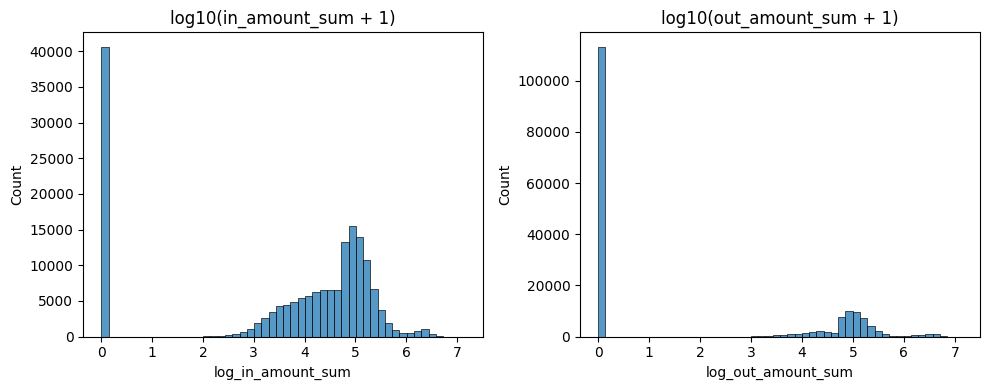

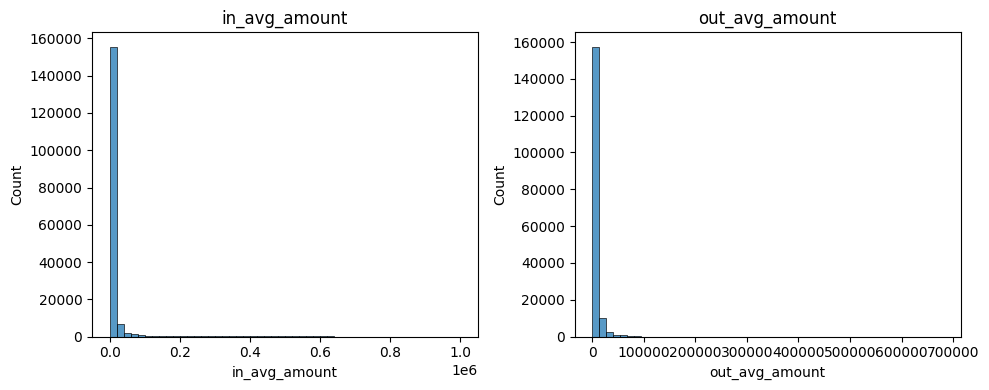

In [19]:
sample_df = node_metrics_df.sample(withReplacement=False, fraction=0.2, seed=42)

sample_pd = sample_df.select(
    "log_in_amount_sum", "log_out_amount_sum",
    "in_amount_sum", "out_amount_sum",
    "in_avg_amount", "out_avg_amount"
).toPandas()

# histograma logs sumas
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.histplot(sample_pd["log_in_amount_sum"], bins=50)
plt.title("log10(in_amount_sum + 1)")

plt.subplot(1,2,2)
sns.histplot(sample_pd["log_out_amount_sum"], bins=50)
plt.title("log10(out_amount_sum + 1)")

plt.tight_layout()
plt.show()

# histograma montos promedio
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.histplot(sample_pd["in_avg_amount"], bins=50)
plt.title("in_avg_amount")

plt.subplot(1,2,2)
sns.histplot(sample_pd["out_avg_amount"], bins=50)
plt.title("out_avg_amount")

plt.tight_layout()
plt.show()


In [20]:
spark.catalog.clearCache()
del sample_df, sample_pd

Entre los picos en 0 están los que nunca recibieron in_amount ni los que nunca enviaron out_amount como se observó con los grados. Los histogramas en logaritmo tienen suficiente resolución como para descubrir mini campanas con mayor actividad entre 4 y 6, es decir con montos entre 10⁴ a 10⁶, hay, eso sí, un par de colas que llegan hasta 10⁷- En otras palabras hay una gran cantidad de cuentas con muy poca actividad, o básicamente sin actividad, y otro grupo pequeño que concentra actividad en montos totales muy grandes. 

Los histogramas de promedio están sumamente sesgados: un pico brutal en cero, y rangos altos de montos promedio donde se ve actividad aunque sea minúscula, es decir, una cola larguísima hacia la derecha. En otras palabras, la mayoría de las cuentas del dataset operan con valores "normales", mientras que un grupo reducido opera a grandes volúmenes, donde cada transacción promedio es enorme, tanto de entrada como de salida. 

En otras palabras, se pueden observar dos tipos de cuentas:
- Cuentas con muchas transacciones (alto grado) pero montos medios moderados
- Cuentas con pocas transacciones pero con montos medios gigantes

## Bivariado 1: grado vs monto

/home/felpipe/1 - UDD/Bank fraud detection/KaggleChallenges/venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
                                                                                

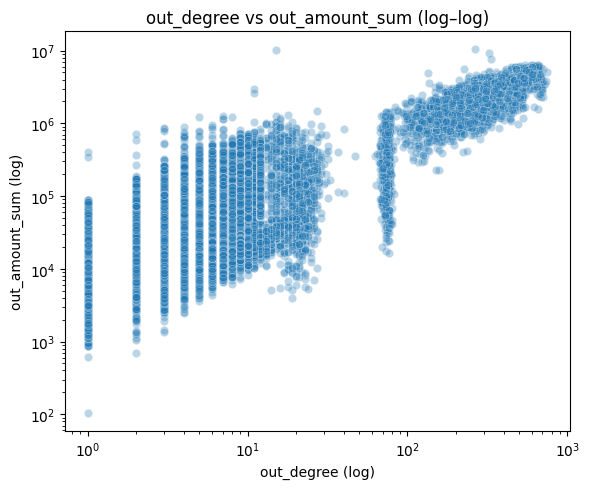

In [21]:
active_out_df = node_metrics_df.filter(
    (F.col("out_degree") > 0) & (F.col("out_amount_sum") > 0)
)

active_out_pd = active_out_df.select(
    "out_degree", "out_amount_sum"
).toPandas()

plt.figure(figsize=(6,5))
sns.scatterplot(
    data=active_out_pd.sample(frac=0.2, random_state=42),  # sub-muestra para no saturar
    x="out_degree",
    y="out_amount_sum",
    alpha=0.3
)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("out_degree (log)")
plt.ylabel("out_amount_sum (log)")
plt.title("out_degree vs out_amount_sum (log–log)")
plt.tight_layout()
plt.show()


Aquí se ve algo interesante que contrasta un poco con lo definido anteriormente. A grandes razgos la tendencia es: a mayor cantidad de transacciones mayor el volumen. No sorprende desde un punto de vista básico, quien envía muchas transacciones suele mover más plata en total. Ahora, la nube se dispersa hacia los grados bajos y se densifica hacia los grados medios en la primera mitad. Con los grados altos se tiene algo interesante. Primero, se separan del resto, casi como mostrando un clúster diferente, incluso un subclúster cercano a 10². Tal vez es la línea divisoria entre ricos y pobres, pero esto es solo una conjetura. Se supone que estos datos son sintéticos, pero tal vez el método de generación tiene de alguna forma este patrón. No se puede descartar que se esté viendo tampoco una clara señal de fraudulencia. 

/home/felpipe/1 - UDD/Bank fraud detection/KaggleChallenges/venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
                                                                                

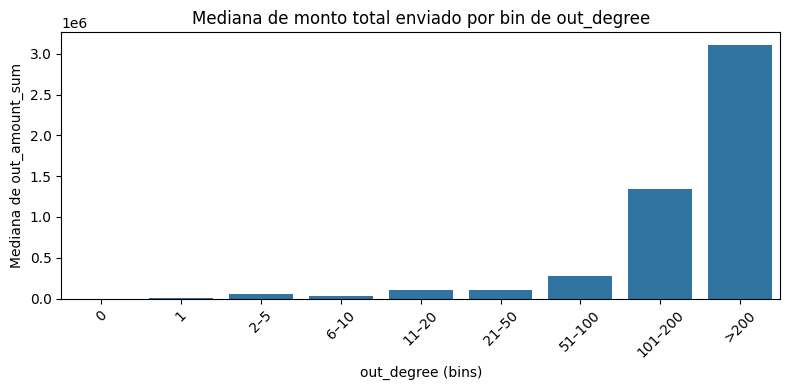

In [22]:
# Usamos los mismos bins de out_degree que definimos antes
deg_bins_order = ["0", "1", "2–5", "6–10", "11–20", "21–50", "51–100", "101–200", ">200"]

node_binned_df = (
    node_metrics_df
    .transform(lambda df: add_degree_bins(df, "out_degree", "out_degree_bin"))
)

# media y mediana de montos por bin
amount_by_bin = (
    node_binned_df
    .groupBy("out_degree_bin")
    .agg(
        F.count("*").alias("n_nodes"),
        F.mean("out_amount_sum").alias("mean_out_amount_sum"),
        F.expr("percentile(out_amount_sum, 0.5)").alias("median_out_amount_sum")
    )
)

amount_by_bin_pd = amount_by_bin.toPandas()
amount_by_bin_pd["out_degree_bin"] = pd.Categorical(
    amount_by_bin_pd["out_degree_bin"],
    categories=deg_bins_order,
    ordered=True
)
amount_by_bin_pd = amount_by_bin_pd.sort_values("out_degree_bin")

plt.figure(figsize=(8,4))
sns.barplot(
    data=amount_by_bin_pd,
    x="out_degree_bin",
    y="median_out_amount_sum"
)
plt.xticks(rotation=45)
plt.xlabel("out_degree (bins)")
plt.ylabel("Mediana de out_amount_sum")
plt.title("Mediana de monto total enviado por bin de out_degree")
plt.tight_layout()
plt.show()


In [23]:
spark.catalog.clearCache()
del active_out_df

Y bueno, este gráfico es la prueba cuantitativa de lo que se veía con el scatter. A medida que más dinero posee una cuenta mucho mayor el el flujo neto que ésta puede mover. 

## Bivariado 2: monto vs fraude

/home/felpipe/1 - UDD/Bank fraud detection/KaggleChallenges/venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
                                                                                

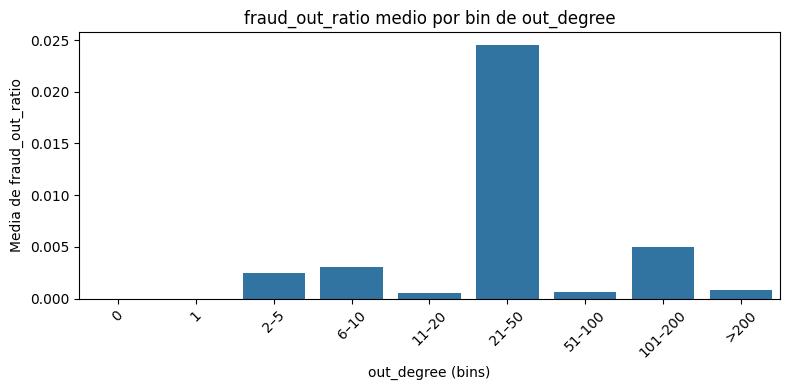

In [24]:
#fraud_out_ratio por bin de grado
fraud_by_deg = (
    node_binned_df
    .groupBy("out_degree_bin")
    .agg(
        F.count("*").alias("n_nodes"),
        F.mean("fraud_out_ratio").alias("mean_fraud_out_ratio"),
        F.expr("percentile(fraud_out_ratio, 0.75)").alias("p75_fraud_out_ratio")
    )
)

fraud_by_deg_pd = fraud_by_deg.toPandas()
fraud_by_deg_pd["out_degree_bin"] = pd.Categorical(
    fraud_by_deg_pd["out_degree_bin"],
    categories=deg_bins_order,
    ordered=True
)
fraud_by_deg_pd = fraud_by_deg_pd.sort_values("out_degree_bin")

plt.figure(figsize=(8,4))
sns.barplot(
    data=fraud_by_deg_pd,
    x="out_degree_bin",
    y="mean_fraud_out_ratio"
)
plt.xticks(rotation=45)
plt.xlabel("out_degree (bins)")
plt.ylabel("Media de fraud_out_ratio")
plt.title("fraud_out_ratio medio por bin de out_degree")
plt.tight_layout()
plt.show()


/home/felpipe/1 - UDD/Bank fraud detection/KaggleChallenges/venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
                                                                                

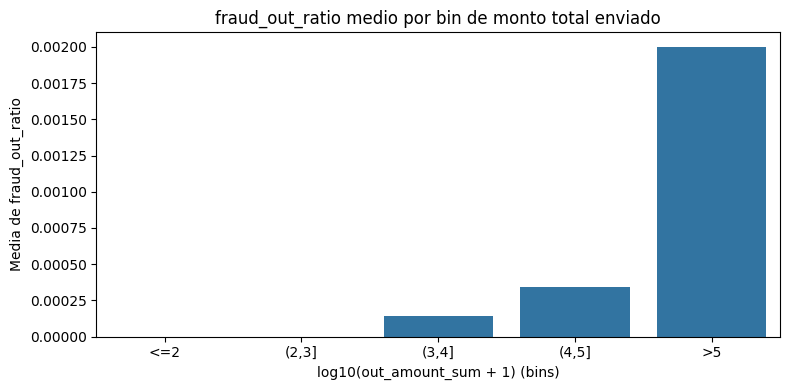

In [25]:
#fraud_out_ratio por bin de monto
# Bins de log montos
node_metrics_df = node_metrics_df.withColumn(
    "log_out_amount_bin",
    F.when(F.col("log_out_amount_sum") <= 2, "<=2")         # hasta ~100
     .when(F.col("log_out_amount_sum") <= 3, "(2,3]")      # ~100–1000
     .when(F.col("log_out_amount_sum") <= 4, "(3,4]")      # ~1k–10k
     .when(F.col("log_out_amount_sum") <= 5, "(4,5]")      # ~10k–100k
     .otherwise(">5")                                      # >100k
)

fraud_by_amount = (
    node_metrics_df
    .groupBy("log_out_amount_bin")
    .agg(
        F.count("*").alias("n_nodes"),
        F.mean("fraud_out_ratio").alias("mean_fraud_out_ratio")
    )
)

fraud_by_amount_pd = fraud_by_amount.toPandas()
amount_order = ["<=2", "(2,3]", "(3,4]", "(4,5]", ">5"]
fraud_by_amount_pd["log_out_amount_bin"] = pd.Categorical(
    fraud_by_amount_pd["log_out_amount_bin"],
    categories=amount_order,
    ordered=True
)
fraud_by_amount_pd = fraud_by_amount_pd.sort_values("log_out_amount_bin")

plt.figure(figsize=(8,4))
sns.barplot(
    data=fraud_by_amount_pd,
    x="log_out_amount_bin",
    y="mean_fraud_out_ratio"
)
plt.xlabel("log10(out_amount_sum + 1) (bins)")
plt.ylabel("Media de fraud_out_ratio")
plt.title("fraud_out_ratio medio por bin de monto total enviado")
plt.tight_layout()
plt.show()


In [26]:
spark.catalog.clearCache()
del node_binned_df

Aquí la relación es más directa. Cuanto mayor es el volumen enviado por la cuenta mayor es la fracción de sus transacciones que son fraude. Se trata de otro patrón fácil de señalar para efectuar eventual clasificación nodal de fraude. 

# Conectividad y componentes

In [27]:
from py2neo import Graph
graph = Graph(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASS), name=NEO4J_DDBB)

## Weakly Connected Components (WCC): estructura global

In [28]:
# Proyección no dirigida para WCC
graph.run("""
CALL gds.graph.project(
  'aml_wcc',
  'Account',
  {
    TX: {
      type: 'TX',
      orientation: 'UNDIRECTED'
    }
  }
);""").data()

[{'nodeProjection': {'Account': {'label': 'Account', 'properties': {}}},
  'relationshipProjection': {'TX': {'aggregation': 'DEFAULT',
    'orientation': 'UNDIRECTED',
    'indexInverse': False,
    'properties': {},
    'type': 'TX'}},
  'graphName': 'aml_wcc',
  'nodeCount': 855460,
  'relationshipCount': 19009704,
  'projectMillis': 25679}]

In [29]:
# Ejecutar WCC y escribir el id de componente en cada nodo
graph.run("""
CALL gds.wcc.write(
  'aml_wcc',
  {
    writeProperty: 'wcc_id'
  }
);""").data()

[{'componentCount': 15592,
  'componentDistribution': {'min': 2,
   'p5': 17,
   'max': 954,
   'p999': 664,
   'p99': 250,
   'p1': 6,
   'p10': 28,
   'p90': 68,
   'p50': 51,
   'p25': 41,
   'p75': 60,
   'p95': 74,
   'mean': 54.86531554643407},
  'preProcessingMillis': 12,
  'computeMillis': 487,
  'postProcessingMillis': 224,
  'writeMillis': 1847,
  'nodePropertiesWritten': 855460,
  'configuration': {'writeProperty': 'wcc_id',
   'jobId': 'd93e7acc-35d2-438d-9efa-addb2d2c2163',
   'logProgress': True,
   'nodeLabels': ['*'],
   'concurrency': 4,
   'relationshipTypes': ['*'],
   'consecutiveIds': False,
   'sudo': False,
   'seedProperty': None,
   'writeToResultStore': False,
   'writeConcurrency': 4,
   'threshold': 0.0}}]

In [30]:
# Cargar membership de componentes desde Neo4j
df_wcc = (
    spark.read.format("org.neo4j.spark.DataSource")
    .options(**opts)  # mismo dict de opciones que ya usas
    .option(
        "query",
        """
        MATCH (a:Account)
        RETURN a.account_number AS account_number,
               a.wcc_id     AS wcc_id
        """
    )
    .load()
)

# Número total de nodos con componente asignada
n_nodes = df_wcc.count()

# Tamaño de cada componente (en número de nodos)
df_wcc_sizes = (
    df_wcc.groupBy("wcc_id")
    .agg(F.count("*").alias("num_nodes"))
    .orderBy(F.desc("num_nodes"))
)

print("Total de nodos con wcc_id:", n_nodes)
df_wcc_sizes.toPandas()[:10]


/home/felpipe/1 - UDD/Bank fraud detection/KaggleChallenges/venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


Total de nodos con wcc_id: 855460


,wcc_id,num_nodes
0,2,954
1,550,894
2,909,859
3,452,834
4,842,807
5,494,802
6,822,746
7,313,738
8,4442,712
9,936,694


In [31]:
#Stats agregados
# Total de componentes
n_components = df_wcc_sizes.count()

# Tamaño del componente gigante
giant_row = df_wcc_sizes.first()
giant_size = giant_row["num_nodes"]
frac_nodes_giant = giant_size / n_nodes

print(f"N° componentes WCC: {n_components}")
print(f"Tamaño componente gigante: {giant_size} nodos ({frac_nodes_giant:.2%} del total)")


[Stage 146:>                                                        (0 + 1) / 1]

N° componentes WCC: 15592
Tamaño componente gigante: 954 nodos (0.11% del total)


In [32]:
wcc_hist = (
    df_wcc_sizes
    .withColumn(
        "size_bin",
        F.when(F.col("num_nodes") == 1, "1")
         .when(F.col("num_nodes") <= 5, "2-5")
         .when(F.col("num_nodes") <= 20, "6-20")
         .when(F.col("num_nodes") <= 100, "21-100")
         .otherwise("100+")
    )
    .groupBy("size_bin")
    .agg(
        F.count("*").alias("num_components"),
        F.sum("num_nodes").alias("total_nodes_in_bin")
    )
    .orderBy("size_bin")
)

wcc_hist.toPandas()


/home/felpipe/1 - UDD/Bank fraud detection/KaggleChallenges/venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
                                                                                

,size_bin,num_components,total_nodes_in_bin
0,100+,514,122209
1,2-5,120,374
2,21-100,14078,720421
3,6-20,880,12456


El grafo no presenta un componente gigante; está formado por 15.5k componentes conexas, de las cuales casi todas tienen entre 21 y 100 nodos. Las componentes de tamaño ≥100 agrupan solo un 14% de las cuentas, y no hay nodos aislados. El dataset sintético se parece más a un conjunto de muchas “subredes locales” relativamente pequeñas que a un sistema bancario global conectado.

In [33]:
#Cruce con fraude
# Asegúrate de tener edges_df con src/dst = account_id
# edges_df.printSchema()

edges_with_comp = (
    edges_df.alias("e")
    .join(df_wcc.alias("s"), F.col("e.src") == F.col("s.account_number"))
    .withColumnRenamed("wcc_id", "wcc_src")
    .join(df_wcc.alias("t"), F.col("e.dst") == F.col("t.account_number"))
    .withColumnRenamed("wcc_id", "wcc_dst")
)

# Por definición de WCC, wcc_src y wcc_dst deberían coincidir siempre
mismatches = edges_with_comp.filter(F.col("wcc_src") != F.col("wcc_dst")).count()
print("Aristas con src y dst en distinta WCC (debería ser 0):", mismatches)

# Aristas por componente + fraude
df_wcc_edges = (
    edges_with_comp
    .groupBy("wcc_src")
    .agg(
        F.count("*").alias("num_edges"),
        F.sum(F.col("is_laundering").cast("int")).alias("num_fraud_edges")
    )
    .withColumnRenamed("wcc_src", "wcc_id")
)

# Unir con tamaños de componente
wcc_summary = (
    df_wcc_sizes.join(df_wcc_edges, "wcc_id", "left")
    .fillna(0, subset=["num_edges", "num_fraud_edges"])
    .withColumn("fraud_edge_ratio", F.col("num_fraud_edges") / F.col("num_edges"))
    .orderBy(F.desc("num_nodes"))
)

wcc_summary.toPandas()


/home/felpipe/1 - UDD/Bank fraud detection/KaggleChallenges/venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


Aristas con src y dst en distinta WCC (debería ser 0): 0


,wcc_id,num_nodes,num_edges,num_fraud_edges,fraud_edge_ratio
0,2,954,9567,47,0.004913
1,550,894,8873,44,0.004959
2,909,859,8642,45,0.005207
3,452,834,8595,40,0.004654
4,842,807,8160,41,0.005025
...,...,...,...,...,...
15587,133406,2,1,0,0.000000
15588,93073,2,1,0,0.000000
15589,11061,2,1,0,0.000000
15590,243990,2,1,0,0.000000


In [34]:
#Resumen
total_fraud_edges = wcc_summary.agg(F.sum("num_fraud_edges")).first()[0]

top10 = wcc_summary.limit(10)
top10_fraud = top10.agg(F.sum("num_fraud_edges")).first()[0]

print(f"Fraude total (aristas): {total_fraud_edges}")
if total_fraud_edges > 0:
    print(f"Fraude dentro de las 10 WCC más grandes: {top10_fraud} "
      f"({top10_fraud/total_fraud_edges:.2%})")

# # Sanity check global
# total_edges = edges_df.count()
# total_fraud_edges = edges_df.filter(F.col("is_laundering") == 1).count()

# print("Total aristas:", total_edges)
# print("Total aristas fraudulentas:", total_fraud_edges)


[Stage 238:========>                                                (1 + 6) / 7]

Fraude total (aristas): 9873
Fraude dentro de las 10 WCC más grandes: 408 (4.13%)


In [35]:
total_fraud_edges = (
    wcc_summary
    .agg(F.sum("num_fraud_edges").alias("total_fraud_edges"))
    .first()["total_fraud_edges"]
)

# Añadir bin de tamaño y agregar fraude por bin
wcc_fraud_by_bin = (
    wcc_summary
    .withColumn(
        "size_bin",
        F.when(F.col("num_nodes") == 1, "1")
         .when(F.col("num_nodes") <= 5, "2-5")
         .when(F.col("num_nodes") <= 20, "6-20")
         .when(F.col("num_nodes") <= 100, "21-100")
         .otherwise("100+")
    )
    .groupBy("size_bin")
    .agg(
        F.count("*").alias("num_components"),
        F.sum("num_nodes").alias("total_nodes_in_bin"),
        F.sum("num_edges").alias("edges_in_bin"),
        F.sum("num_fraud_edges").alias("fraud_edges_in_bin"),
    )
    .withColumn(
        "fraud_edge_ratio",
        F.col("fraud_edges_in_bin") / F.col("edges_in_bin")
    )
    .withColumn(
        "fraud_share",
        F.col("fraud_edges_in_bin") / F.lit(total_fraud_edges)
    )
    .orderBy("size_bin")
)

wcc_fraud_by_bin_pdf = wcc_fraud_by_bin.toPandas()
wcc_fraud_by_bin_pdf

/home/felpipe/1 - UDD/Bank fraud detection/KaggleChallenges/venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
                                                                                

,size_bin,num_components,total_nodes_in_bin,edges_in_bin,fraud_edges_in_bin,fraud_edge_ratio,fraud_share
0,100+,514,122209,1229799,6590,0.005359,0.667477
1,2-5,120,374,1278,0,0.000000,0.000000
2,21-100,14078,720421,7786213,2993,0.000384,0.303150
3,6-20,880,12456,487562,290,0.000595,0.029373


In [36]:
# Filtrar componentes con al menos cierto volumen para evitar ruido
suspicious_wcc = (
    wcc_summary
    .filter((F.col("num_edges") >= 50) & (F.col("num_fraud_edges") > 0))
    .orderBy(F.desc("fraud_edge_ratio"))
    .limit(20)
)

suspicious_wcc_pdf = suspicious_wcc.toPandas()
suspicious_wcc_pdf

/home/felpipe/1 - UDD/Bank fraud detection/KaggleChallenges/venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
                                                                                

,wcc_id,num_nodes,num_edges,num_fraud_edges,fraud_edge_ratio
0,70786,12,64,19,0.296875
1,12447,23,209,22,0.105263
2,26420,21,200,21,0.105000
3,34443,20,192,20,0.104167
4,36908,26,270,28,0.103704
5,2225,23,223,23,0.103139
6,55293,23,201,20,0.099502
7,30921,19,167,15,0.089820
8,721,34,292,26,0.089041
9,7497,26,225,20,0.088889


In [37]:
spark.catalog.clearCache()
del df_wcc, df_wcc_sizes, n_components, frac_nodes_giant, wcc_hist
del edges_with_comp, df_wcc_edges, wcc_summary, wcc_fraud_by_bin
del wcc_fraud_by_bin_pdf, suspicious_wcc, suspicious_wcc_pdf

Fragmentación global (WCC)
El grafo está compuesto por ~15.6k componentes conexas sin dirección. No hay un componente gigante; la más grande tiene 954 nodos. La mayor parte de las cuentas se agrupa en WCC de tamaño entre 21 y 100 nodos, mientras que las WCC de tamaño ≥100 concentran una fracción menor pero no despreciable de las cuentas.

Fraude por tamaño de componente
Al mirar el fraude por rango de tamaño de WCC, se observa que:

- El fraude no está concentrado en unas pocas componentes gigantes: las 10 WCC más grandes explican solo ≈4% de las aristas fraudulentas.
- La mayor parte del fraude se reparte entre muchas WCC de tamaño medio (21–100 nodos), coherente con un dataset formado por múltiples “subredes locales” independientes.
- Existen algunas WCC con densidad de fraude significativamente mayor que la media. Esas componentes son buenas candidatas a “subredes calientes” y puntos de partida para inspección manual y futuros features de comunidad (por ejemplo: proporción de vecinos en WCC de alta densidad de fraude).

## Strongly Connected Components (SCC): ciclos y feedback

In [41]:
# Proyección dirigida
graph.run("""
CALL gds.graph.project(
  'aml_scc',
  'Account',
  'TX'
);""").data()

[{'nodeProjection': {'Account': {'label': 'Account', 'properties': {}}},
  'relationshipProjection': {'TX': {'aggregation': 'DEFAULT',
    'orientation': 'NATURAL',
    'indexInverse': False,
    'properties': {},
    'type': 'TX'}},
  'graphName': 'aml_scc',
  'nodeCount': 855460,
  'relationshipCount': 9504852,
  'projectMillis': 21246}]

In [42]:
# SCC dirigida
graph.run("""
CALL gds.scc.write(
  'aml_scc',
  {
    writeProperty: 'scc_id'
  }
);""").data()

[{'componentCount': 808212,
  'componentDistribution': {'min': 1,
   'p5': 1,
   'max': 34,
   'p999': 6,
   'p99': 3,
   'p1': 1,
   'p10': 1,
   'p90': 1,
   'p50': 1,
   'p25': 1,
   'p75': 1,
   'p95': 1,
   'mean': 1.0584599090337683},
  'preProcessingMillis': 13,
  'computeMillis': 477,
  'postProcessingMillis': 542,
  'writeMillis': 6187,
  'nodePropertiesWritten': 855460,
  'configuration': {'writeProperty': 'scc_id',
   'jobId': 'c4d14123-6c35-44a2-8e91-4b010c5748ea',
   'logProgress': True,
   'nodeLabels': ['*'],
   'relationshipTypes': ['*'],
   'concurrency': 4,
   'consecutiveIds': False,
   'sudo': False,
   'writeToResultStore': False,
   'writeConcurrency': 4}}]

In [43]:
df_scc = (
    spark.read.format("org.neo4j.spark.DataSource")
    .options(**opts)
    .option(
        "query",
        """
        MATCH (a:Account)
        RETURN a.account_number AS account_number,
               a.scc_id         AS scc_id
        """
    )
    .load()
)

df_scc_sizes = (
    df_scc.groupBy("scc_id")
    .agg(F.count("*").alias("num_nodes"))
    .orderBy(F.desc("num_nodes"))
)
print(df_scc_sizes.toPandas())
n_scc = df_scc_sizes.count()
print("N° de SCC:", n_scc)

/home/felpipe/1 - UDD/Bank fraud detection/KaggleChallenges/venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
                                                                                

        scc_id  num_nodes
0        10368         34
1         1980         30
2        61946         29
3       371998         28
4         7489         27
...        ...        ...
808207  855066          1
808208  855167          1
808209  855170          1
808210  855232          1
808211  855262          1

[808212 rows x 2 columns]


[Stage 328:>                                                        (0 + 1) / 1]

N° de SCC: 808212


In [44]:
# SCC de tamaño 1 (sin ciclos no triviales)
df_scc_size1 = df_scc_sizes.filter(F.col("num_nodes") == 1)
# SCC no triviales (>=2 nodos)
df_scc_big = df_scc_sizes.filter(F.col("num_nodes") >= 2)

print("SCC tamaño 1:", df_scc_size1.count())
print("SCC tamaño >=2:", df_scc_big.count())


SCC tamaño 1: 789218


[Stage 340:>                                                        (0 + 1) / 1]

SCC tamaño >=2: 18994


In [45]:
nodes_in_nontrivial_scc = df_scc_big.agg(F.sum("num_nodes")).first()[0]
print("Nodos en SCC no triviales:", nodes_in_nontrivial_scc)


[Stage 346:>                                                        (0 + 1) / 1]

Nodos en SCC no triviales: 66242


In [46]:
#SSC + fraude
edges_with_scc = (
    edges_df.alias("e")
    .join(df_scc.alias("s"), F.col("e.src") == F.col("s.account_number"))
    .withColumnRenamed("scc_id", "scc_src")
    .join(df_scc.alias("t"), F.col("e.dst") == F.col("t.account_number"))
    .withColumnRenamed("scc_id", "scc_dst")
)

# Nos interesan aristas dentro de la misma SCC (ciclos internos)
edges_in_scc = edges_with_scc.filter(F.col("scc_src") == F.col("scc_dst"))

scc_fraud_summary = (
    edges_in_scc
    .groupBy("scc_src")
    .agg(
        F.count("*").alias("num_edges"),
        F.sum(F.col("is_laundering").cast("int")).alias("num_fraud_edges")
    )
    .withColumnRenamed("scc_src", "scc_id")
    .join(df_scc_big, "scc_id", "inner")  # solo SCC >=2 nodos
    .withColumn("fraud_edge_ratio", F.col("num_fraud_edges") / F.col("num_edges"))
    .orderBy(F.desc("fraud_edge_ratio"))
)

scc_fraud_summary.toPandas()


/home/felpipe/1 - UDD/Bank fraud detection/KaggleChallenges/venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
                                                                                

,scc_id,num_edges,num_fraud_edges,num_nodes,fraud_edge_ratio
0,8951,42,12,18,0.285714
1,103549,18,5,8,0.277778
2,188681,45,10,16,0.222222
3,481342,23,5,8,0.217391
4,352628,36,7,13,0.194444
...,...,...,...,...,...
18989,714420,6,0,2,0.000000
18990,770719,21,0,4,0.000000
18991,717679,6,0,2,0.000000
18992,720352,4,0,2,0.000000


In [47]:
# Fraude total (de nuevo, desde edges_df)
total_fraud_edges_global = (
    edges_df
    .filter(F.col("is_laundering") == 1)
    .count()
)

fraud_edges_in_nontrivial_scc = (
    scc_fraud_summary
    .agg(F.sum("num_fraud_edges").alias("fraud_edges_in_scc"))
    .first()["fraud_edges_in_scc"]
)

print("Fraude total (aristas):", total_fraud_edges_global)
print("Fraude en SCC no triviales:", fraud_edges_in_nontrivial_scc)
if total_fraud_edges_global > 0:
    print("Proporción:",
          fraud_edges_in_nontrivial_scc / total_fraud_edges_global)


Fraude total (aristas): 9873
Fraude en SCC no triviales: 367
Proporción: 0.037172085485667986


In [48]:
scc_fraud_by_bin = (
    scc_fraud_summary
    .withColumn(
        "size_bin",
        F.when(F.col("num_nodes") <= 3, "2-3")
         .when(F.col("num_nodes") <= 10, "4-10")
         .otherwise("11+")
    )
    .groupBy("size_bin")
    .agg(
        F.count("*").alias("num_scc"),
        F.sum("num_nodes").alias("nodes_in_bin"),
        F.sum("num_edges").alias("edges_in_bin"),
        F.sum("num_fraud_edges").alias("fraud_edges_in_bin"),
    )
    .withColumn(
        "fraud_edge_ratio",
        F.col("fraud_edges_in_bin") / F.col("edges_in_bin")
    )
    .withColumn(
        "fraud_share",
        F.col("fraud_edges_in_bin") / F.lit(total_fraud_edges_global)
    )
    .orderBy("size_bin")
)

scc_fraud_by_bin_pdf = scc_fraud_by_bin.toPandas()
scc_fraud_by_bin_pdf


/home/felpipe/1 - UDD/Bank fraud detection/KaggleChallenges/venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
                                                                                

,size_bin,num_scc,nodes_in_bin,edges_in_bin,fraud_edges_in_bin,fraud_edge_ratio,fraud_share
0,11+,450,6272,464857,352,0.000757,0.035653
1,2-3,12170,29738,106770,0,0.000000,0.000000
2,4-10,6374,30232,206394,15,0.000073,0.001519


In [49]:
suspicious_scc = (
    scc_fraud_summary
    .filter(
        (F.col("num_edges") >= 3) &  # al menos 3 transferencias internas
        (F.col("num_fraud_edges") >= 1)  # al menos una fraudulenta
    )
    .orderBy(F.desc("fraud_edge_ratio"))
    .limit(20)
)

suspicious_scc_pdf = suspicious_scc.toPandas()
suspicious_scc_pdf


/home/felpipe/1 - UDD/Bank fraud detection/KaggleChallenges/venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
                                                                                

,scc_id,num_edges,num_fraud_edges,num_nodes,fraud_edge_ratio
0,8951,42,12,18,0.285714
1,103549,18,5,8,0.277778
2,188681,45,10,16,0.222222
3,481342,23,5,8,0.217391
4,352628,36,7,13,0.194444
5,169402,26,5,10,0.192308
6,7825,53,10,17,0.188679
7,429641,49,9,17,0.183673
8,28109,61,11,20,0.180328
9,13231,77,13,24,0.168831


In [50]:
spark.catalog.clearCache()
del df_scc, df_scc_sizes, n_scc, df_scc_size1, df_scc_big
del nodes_in_nontrivial_scc, edges_with_scc, edges_in_scc, scc_fraud_summary
del total_fraud_edges_global, fraud_edges_in_nontrivial_scc, scc_fraud_by_bin
del scc_fraud_by_bin_pdf, suspicious_scc, suspicious_scc_pdf

Ciclos dirigidos (SCC)
A nivel global, el grafo presenta ~808k componentes fuertemente conexas, de las cuales ~789k son triviales (tamaño 1). Solo unas decenas de miles de nodos participan en SCC no triviales, y la SCC más grande tiene 34 nodos, lo que sugiere una topología mayormente acíclica con muchos circuitos pequeños.

Al cruzar con fraude, una fracción limitada de las aristas fraudulentas cae dentro de SCC no triviales, pero los ciclos que sí contienen fraude tienden a tener una densidad de fraude (fraud_edge_ratio) mayor que la media. Esto es coherente con patrones de AML como:

- cadenas cortas de layering (A → B → C → … → A),
- devoluciones/reembolsos encadenados,
- pequeños grupos de cuentas que se retroalimentan entre sí.

Los SCC con mayor fraud_edge_ratio y tamaño pequeño/medio son buenos candidatos a “motifs circulares” de lavado que luego podremos usar como semillas para:

- features de nodo (flag “participa en ciclo fraudulento”, tamaño del ciclo, etc.),
- extracción explícita de patrones y reglas,
- entrenamiento de modelos de detección basados en subgrafos.

# Comunidades y “subredes calientes”

## Comunidades Louvain

In [52]:
louvain_result = graph.run("""
CALL gds.louvain.write('aml_wcc', {
  writeProperty: 'louvain_id'
})
YIELD communityCount, modularity
""").data()

print("Resultado Louvain:", louvain_result)

Resultado Louvain: [{'communityCount': 15729, 'modularity': 0.9998829999922507}]


La red se descompone en ~15.7k comunidades Louvain, con fuerte modularidad, lo que sugiere grupos bien definidos de cuentas que transan preferentemente entre sí.

In [53]:
louvain_nodes_query = """
MATCH (a:Account)
RETURN
  a.account_number AS account_number,
  a.louvain_id     AS louvain_id
"""

df_louvain = (
    spark.read
        .format("org.neo4j.spark.DataSource")
        .option("url", NEO4J_URI)
        .option("authentication.type", "basic")
        .option("authentication.basic.username", NEO4J_USER)
        .option("authentication.basic.password", NEO4J_PASS)
        .option("database", NEO4J_DDBB)
        .option("query", louvain_nodes_query)
        .load()
)

df_louvain = df_louvain.filter(F.col("louvain_id").isNotNull())
df_louvain.cache()

df_louvain.printSchema()
df_louvain.show(5, truncate=False)

# --- Tamaño de cada comunidad (nº de nodos) ---

community_sizes = (
    df_louvain
    .groupBy("louvain_id")
    .agg(F.count("*").alias("num_nodes"))
)

print("Número de comunidades:", community_sizes.count())

# Para inspección rápida en pandas (tabla pequeña):
community_sizes_pdf = (
    community_sizes
    .orderBy(F.desc("num_nodes"))
    .limit(20)
    .toPandas()
)
community_sizes_pdf


root
 |-- account_number: long (nullable = true)
 |-- louvain_id: long (nullable = true)



+--------------+----------+
|account_number|louvain_id|
+--------------+----------+
|4651102136    |418931    |
|3647155427    |450710    |
|8986636663    |358966    |
|196361780     |203543    |
|3775525103    |575675    |
+--------------+----------+
only showing top 5 rows



/home/felpipe/1 - UDD/Bank fraud detection/KaggleChallenges/venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


Número de comunidades: 15729


,louvain_id,num_nodes
0,586189,954
1,747929,894
2,71985,859
3,315648,834
4,354904,807
5,682855,802
6,472675,746
7,330565,738
8,779330,712
9,193008,694


In [54]:
#Bins de tamaño

community_size_bins = (
    community_sizes
    .withColumn(
        "size_bin",
        F.when(F.col("num_nodes") <= 5, "1-5")
         .when(F.col("num_nodes") <= 20, "6-20")
         .when(F.col("num_nodes") <= 100, "21-100")
         .otherwise("101+")
    )
    .groupBy("size_bin")
    .agg(
        F.count("*").alias("num_communities"),
        F.sum("num_nodes").alias("nodes_in_bin")
    )
    .orderBy("size_bin")
)

community_size_bins_pdf = community_size_bins.toPandas()
community_size_bins_pdf

/home/felpipe/1 - UDD/Bank fraud detection/KaggleChallenges/venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


,size_bin,num_communities,nodes_in_bin
0,1-5,120,374
1,101+,506,112268
2,21-100,14221,730331
3,6-20,882,12487


Las comunidades se reparten entre muchas células pequeñas y unas pocas macro-comunidades de cientos de nodos y miles de aristas internas.

## Fraude interno por comunidad y “subredes calientes”

In [55]:
#Enriquecer aristas con comunidad de origen y destino
edges_with_comm = (
    edges_df
    .join(
        df_louvain.alias("s"),
        F.col("src") == F.col("s.account_number"),
        "left"
    )
    .withColumnRenamed("louvain_id", "louvain_src")
    .drop("account_number")
    .join(
        df_louvain.alias("t"),
        F.col("dst") == F.col("t.account_number"),
        "left"
    )
    .withColumnRenamed("louvain_id", "louvain_dst")
    .drop("account_number")
)

# Sanity check: ¿cuántas aristas no tienen comunidad anotada?
missing_comm = (
    edges_with_comm
    .filter(F.col("louvain_src").isNull() | F.col("louvain_dst").isNull())
    .count()
)
print("Aristas con src/dst sin louvain_id:", missing_comm)


[Stage 487:========================================>                (5 + 2) / 7]

Aristas con src/dst sin louvain_id: 0


In [56]:
#Solo aristas internas de comunidad (para definir "subred" como comunidad)
internal_edges = edges_with_comm.filter(F.col("louvain_src") == F.col("louvain_dst"))

#Se enriquece con nº de aristas, fraude y volumen total por comunidad:
df_comm_edges = (
    internal_edges
    .groupBy("louvain_src")
    .agg(
        F.count("*").alias("num_edges"),
        F.sum(F.col("is_laundering").cast("int")).alias("num_fraud_edges"),
        F.sum("amount").alias("amount_sum")
    )
    .withColumnRenamed("louvain_src", "louvain_id")
)


In [57]:
comm_summary = (
    community_sizes
    .join(df_comm_edges, "louvain_id", "left")
    .fillna(0, subset=["num_edges", "num_fraud_edges", "amount_sum"])
    .withColumn(
        "fraud_edge_ratio",
        F.when(F.col("num_edges") > 0,
               F.col("num_fraud_edges") / F.col("num_edges")
        ).otherwise(F.lit(0.0))
    )
)

comm_summary.cache()
comm_summary.printSchema()


root
 |-- louvain_id: long (nullable = true)
 |-- num_nodes: long (nullable = false)
 |-- num_edges: long (nullable = true)
 |-- num_fraud_edges: long (nullable = true)
 |-- amount_sum: double (nullable = false)
 |-- fraud_edge_ratio: double (nullable = true)



In [58]:
#calculamos el share de fraude global que explica cada comunidad
total_fraud_edges = edges_df.filter(F.col("is_laundering") == 1).count()
print("Total aristas fraudulentas en el grafo:", total_fraud_edges)

comm_summary = comm_summary.withColumn(
    "fraud_edge_share",
    F.when(F.lit(total_fraud_edges) > 0,
           F.col("num_fraud_edges") / F.lit(total_fraud_edges)
    ).otherwise(F.lit(0.0))
)


[Stage 494:>                                                        (0 + 1) / 1]

Total aristas fraudulentas en el grafo: 9873


In [59]:
spark.catalog.clearCache()
del community_sizes, edges_with_comm, missing_comm, internal_edges, df_comm_edges

## Selección de “subredes calientes”

Se define comunidades sospechosas como aquellas que:

- Tienen al menos cierto tamaño en nodos y aristas (para evitar ruido de comunidades minúsculas),
- Tienen alta densidad de fraude (fraud_edge_ratio) o explican una fracción grande del fraude total (fraud_edge_share).

In [60]:
suspicious_communities = (
    comm_summary
    .filter((F.col("num_nodes") >= 5) & (F.col("num_edges") >= 20))
    .orderBy(F.desc("fraud_edge_ratio"))
    .limit(20)
)

suspicious_communities_pdf = suspicious_communities.toPandas()
suspicious_communities_pdf


/home/felpipe/1 - UDD/Bank fraud detection/KaggleChallenges/venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
                                                                                

,louvain_id,num_nodes,num_edges,num_fraud_edges,amount_sum,fraud_edge_ratio,fraud_edge_share
0,135898,11,28,9,1254590.14,0.321429,0.000912
1,178494,12,64,19,620387.54,0.296875,0.001924
2,22796,23,209,22,2102689.78,0.105263,0.002228
3,484574,21,200,21,2913714.91,0.105000,0.002127
4,75851,20,192,20,2287076.50,0.104167,0.002026
5,633702,12,48,5,1401069.63,0.104167,0.000506
6,300159,26,270,28,1894303.70,0.103704,0.002836
7,772947,23,223,23,2090971.04,0.103139,0.002330
8,93151,23,201,20,3522263.85,0.099502,0.002026
9,356308,19,167,15,1791384.45,0.089820,0.001519


In [61]:
top_fraud_share = (
    comm_summary
    .filter(F.col("num_fraud_edges") > 0)
    .orderBy(F.desc("fraud_edge_share"))
    .limit(20)
)

top_fraud_share_pdf = top_fraud_share.toPandas()
top_fraud_share_pdf


/home/felpipe/1 - UDD/Bank fraud detection/KaggleChallenges/venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
                                                                                

,louvain_id,num_nodes,num_edges,num_fraud_edges,amount_sum,fraud_edge_ratio,fraud_edge_share
0,586189,954,9567,47,79956622.54,0.004913,0.004760
1,71985,859,8642,45,81343511.95,0.005207,0.004558
2,747929,894,8873,44,81566885.78,0.004959,0.004457
3,682855,802,8074,42,65705767.56,0.005202,0.004254
4,354904,807,8160,41,71226587.12,0.005025,0.004153
5,315648,834,8595,40,76808635.40,0.004654,0.004051
6,472675,746,7624,38,63284872.85,0.004984,0.003849
7,330565,738,7257,38,67512470.30,0.005236,0.003849
8,165834,664,6469,38,53858765.32,0.005874,0.003849
9,779330,712,7228,37,61497749.13,0.005119,0.003748


Este es el equivalente de las WCC calientes, pero a nivel de comunidad Louvain.

Las comunidades más contaminadas (fraud_edge_ratio ≥ 0.1–0.3) son pequeñas (10–30 nodos) y concentran una fracción elevada de fraude relativo a su tamaño, aunque su contribución al fraude total sea pequeña.

In [62]:
#Análisis bivariado de tamaño vs densidad de fraude para ver si el "calor" se da en comunidades pequeñas/medianas/grandes
comm_bins = (
    comm_summary
    .withColumn(
        "size_bin",
        F.when(F.col("num_nodes") <= 5, "1-5")
         .when(F.col("num_nodes") <= 20, "6-20")
         .when(F.col("num_nodes") <= 100, "21-100")
         .otherwise("101+")
    )
    .groupBy("size_bin")
    .agg(
        F.count("*").alias("num_communities"),
        F.avg("fraud_edge_ratio").alias("avg_fraud_edge_ratio"),
        F.sum("num_fraud_edges").alias("fraud_edges_in_bin"),
        F.sum("num_edges").alias("edges_in_bin")
    )
    .withColumn(
        "fraud_share",
        F.col("fraud_edges_in_bin") / F.lit(total_fraud_edges)
    )
    .orderBy("size_bin")
)

comm_bins_pdf = comm_bins.toPandas()
comm_bins_pdf


/home/felpipe/1 - UDD/Bank fraud detection/KaggleChallenges/venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
                                                                                

,size_bin,num_communities,avg_fraud_edge_ratio,fraud_edges_in_bin,edges_in_bin,fraud_share
0,1-5,120,0.000000,0,1278,0.000000
1,101+,506,0.005465,6009,1131188,0.608630
2,21-100,14221,0.000500,3379,7884341,0.342247
3,6-20,882,0.001534,290,487850,0.029373


Las comunidades que más fraude absorben en términos absolutos son grandes (600–900+ nodos), con ratios de fraude bajos (~0.5%), donde el fraude se camufla entre muchas transacciones legítimas.

Esto sugiere dos modos de operación: (i) células de fraude intensivo y (ii) nodos sospechosos insertos en ecosistemas grandes donde el fraude es minoritario pero volumétricamente relevante.

In [63]:
# Ejemplo de subred caliente (subgrafo) para inspección
import pandas as pd
import networkx as nx

# Tomamos la comunidad más caliente según el criterio anterior
hot_comm_id = int(suspicious_communities_pdf["louvain_id"].iloc[0])
print("Ejemplo de comunidad caliente:", hot_comm_id)

hot_comm_query = """
MATCH (a:Account)-[r:TX]->(b:Account)
WHERE a.louvain_id = $cid AND b.louvain_id = $cid
RETURN
  a.account_number AS src,
  b.account_number AS dst,
  r.amount         AS amount,
  r.is_laundering  AS is_laundering
"""

hot_edges_pdf = graph.run(hot_comm_query, cid=hot_comm_id).to_data_frame()
print("Nº de nodos únicos en la comunidad caliente:",
      pd.unique(hot_edges_pdf[["src", "dst"]].values.ravel()).shape[0])
print("Nº de aristas internas:", len(hot_edges_pdf))

G_hot = nx.from_pandas_edgelist(
    hot_edges_pdf,
    source="src",
    target="dst",
    edge_attr=["amount", "is_laundering"],
    create_using=nx.DiGraph()
)

Ejemplo de comunidad caliente: 135898
Nº de nodos únicos en la comunidad caliente: 11
Nº de aristas internas: 28


In [64]:
num_nodes = G_hot.number_of_nodes()
num_edges = G_hot.number_of_edges()
is_directed = G_hot.is_directed()

print(f"Grafo {'dirigido' if is_directed else 'no dirigido'}")
print(f" - Nº de nodos:  {num_nodes}")
print(f" - Nº de aristas: {num_edges}")

# Si quieres algo AML-relevante:
num_fraud_edges = sum(
    1 for _, _, d in G_hot.edges(data=True)
    if d.get("is_laundering", 0) == 1
)
print(f" - Nº de aristas fraudulentas: {num_fraud_edges}")


Grafo dirigido
 - Nº de nodos:  11
 - Nº de aristas: 12
 - Nº de aristas fraudulentas: 1


In [65]:
spark.catalog.clearCache()
del num_edges, num_fraud_edges, total_fraud_edges
del comm_summary, top_fraud_share_pdf, comm_bins, comm_bins_pdf
del hot_comm_query, hot_edges_pdf

# Centralidades (degree, betweenness, PageRank…)

La centralidad más sencilla, el degree ya fue analizada, esta sección se enfoca en centralidades más específicas.

Para degree centrality, ver opción de calcular, a partir de:

- in-degree: nº de aristas que llegan al nodo.
- out-degree: nº de aristas que salen del nodo.

Versión ponderada:

- in-strength: suma de montos que entran.
- out-strength: suma de montos que salen.
- 

En AML, qué nos cuenta:

- Hubs de recepción: alto in-degree/in-strength → cuentas donde mucha gente envía dinero.
- Posibles cuentas colectoras, empresas muy usadas como “pantalla”, o cuentas de concentración de fondos.
- Hubs de dispersión: alto out-degree/out-strength → cuentas que mandan dinero a mucha gente.
- Posibles cuentas mulas distribuyendo fondos, payroll sospechoso, etc.
- Asimetrías: out >> in o in >> out en una ventana de tiempo pueden indicar:
  - Cuenta colectora (in>>out) → recibe de muchos, paga a pocos.
  - Cuenta de dispersión (out>>in) → recibe de pocos, paga a muchos.
- Qué queremos medir aquí:
  - Distribución global de grados (in, out, total).
- Top-k cuentas por:
  - in-degree, out-degree.
  - in-strength, out-strength (usando montos).
- Proporción de aristas fraudulentas asociadas a nodos de alto grado:
  - ¿Se concentra el fraude en los hubs o en nodos de grado medio/bajo?

## K-core

k-core / coreness (derivado de degree)

Qué es:

- Un k-core es el subgrafo donde todos los nodos tienen grado ≥ k (dentro del k-core).
- La coreness de un nodo es el k máximo para el cual el nodo pertenece al k-core.

Interpretación AML:

- Captura nodos que están en el “núcleo” densamente conectado de la red.
- Un nodo con coreness alta:
- No solo tiene muchas conexiones, sino que sus vecinos también están bien conectados entre sí.
- Suele pertenecer a “ecosistemas” de transacción estables (empresas, clusters de clientes, etc.).

Qué queremos medir:

- Distribución de coreness.

Si los nodos con coreness alta están:

- mayormente limpios (núcleo del sistema legítimo),
- o si hay células frauduletas incrustadas en ese núcleo.


In [66]:
kcore_result = graph.run("""
CALL gds.kcore.write('aml_wcc', {
  writeProperty: 'kcore',
  concurrency: 4
})
YIELD *
""").data()

print("Resultado K-core:", kcore_result[:3])  # muestra primeras filas


Resultado K-core: [{'nodePropertiesWritten': 855460, 'degeneracy': 161, 'preProcessingMillis': 0, 'computeMillis': 2222, 'postProcessingMillis': 0, 'writeMillis': 843, 'configuration': {'writeProperty': 'kcore', 'jobId': 'd44806f2-75fa-4abc-8545-8ad5eaad21e8', 'logProgress': True, 'nodeLabels': ['*'], 'relationshipTypes': ['*'], 'concurrency': 4, 'sudo': False, 'writeToResultStore': False, 'writeConcurrency': 4}}]


In [67]:
from pyspark.sql import functions as F

kcore_nodes_query = """
MATCH (a:Account)
RETURN
  a.account_number AS account_number,
  a.kcore          AS kcore
"""

df_kcore = (
    spark.read
        .format("org.neo4j.spark.DataSource")
        .option("url", NEO4J_URI)
        .option("authentication.type", "basic")
        .option("authentication.basic.username", NEO4J_USER)
        .option("authentication.basic.password", NEO4J_PASS)
        .option("database", NEO4J_DDBB)
        .option("query", kcore_nodes_query)
        .load()
)

df_kcore = df_kcore.filter(F.col("kcore").isNotNull())
df_kcore.cache()

df_kcore.printSchema()
#df_kcore.show(5, truncate=False)
df_kcore_pdf = (
    df_kcore
    .limit(5)
    .toPandas()
)
df_kcore_pdf


root
 |-- account_number: long (nullable = true)
 |-- kcore: long (nullable = true)



/home/felpipe/1 - UDD/Bank fraud detection/KaggleChallenges/venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
                                                                                

,account_number,kcore
0,4651102136,12
1,3647155427,12
2,8986636663,9
3,196361780,16
4,3775525103,14


In [68]:
# Niveles distintos de k-core
kcore_levels = df_kcore.select("kcore").distinct().count()
print("Niveles distintos de k-core:", kcore_levels)

kcore_sizes = (
    df_kcore
    .groupBy("kcore")
    .agg(F.count("*").alias("num_nodes"))
)

#kcore_sizes.orderBy("kcore").show(50, truncate=False)

# Para tablas/plots (pocos niveles → ok en pandas)
kcore_sizes_pdf = (
    kcore_sizes
    .orderBy(F.desc("num_nodes"))
    .toPandas()
)
kcore_sizes_pdf


Niveles distintos de k-core: 83


/home/felpipe/1 - UDD/Bank fraud detection/KaggleChallenges/venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


,kcore,num_nodes
0,12,215203
1,13,198703
2,1,69561
3,8,27439
4,10,27265
...,...,...
78,135,2
79,133,2
80,134,2
81,55,2


In [69]:
node_metrics_with_kcore = (
    node_metrics_df
    .join(df_kcore, on="account_number", how="left")
)

# Si hubiera algún nodo sin kcore (no debería, pero por si acaso):
node_metrics_with_kcore = node_metrics_with_kcore.fillna({"kcore": 0})

node_metrics_with_kcore.printSchema()
node_metrics_with_kcore_pdf = node_metrics_with_kcore.limit(5).toPandas()

node_metrics_with_kcore_pdf

root
 |-- account_number: long (nullable = true)
 |-- location: string (nullable = true)
 |-- current_balance: double (nullable = true)
 |-- first_seen: timestamp (nullable = true)
 |-- last_seen: timestamp (nullable = true)
 |-- out_degree: long (nullable = true)
 |-- out_amount_sum: double (nullable = false)
 |-- fraud_out_count: long (nullable = true)
 |-- in_degree: long (nullable = true)
 |-- in_amount_sum: double (nullable = false)
 |-- fraud_in_count: long (nullable = true)
 |-- fraud_out_ratio: double (nullable = true)
 |-- fraud_in_ratio: double (nullable = true)
 |-- neighbors_count: long (nullable = false)
 |-- fraud_neighbors_count: long (nullable = false)
 |-- fraud_neighbors_ratio: double (nullable = true)
 |-- out_avg_amount: double (nullable = true)
 |-- in_avg_amount: double (nullable = true)
 |-- log_out_amount_sum: double (nullable = true)
 |-- log_in_amount_sum: double (nullable = true)
 |-- log_out_amount_bin: string (nullable = false)
 |-- kcore: long (nullable = 

/home/felpipe/1 - UDD/Bank fraud detection/KaggleChallenges/venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
                                                                                

,account_number,location,current_balance,first_seen,last_seen,out_degree,out_amount_sum,fraud_out_count,in_degree,in_amount_sum,...,fraud_in_ratio,neighbors_count,fraud_neighbors_count,fraud_neighbors_ratio,out_avg_amount,in_avg_amount,log_out_amount_sum,log_in_amount_sum,log_out_amount_bin,kcore
0,23159,UK,107774.480000,2023-05-21 23:37:05,2023-05-22 16:51:44,0,0.000000e+00,0,13,107774.48,...,0.000000,1,0,0.000000,0.000000,8290.344615,0.000000,5.032520,<=2,13
1,58673,UK,-77.340000,2023-04-14 07:25:26,2023-05-16 09:07:19,1,6.978720e+03,0,1,6901.38,...,0.000000,1,0,0.000000,6978.720000,6901.380000,3.843838,3.838999,"(3,4]",2
2,92172,UK,-967921.640266,2022-10-07 18:27:52,2023-08-22 15:05:17,268,1.047414e+06,2,17,79492.37,...,0.058824,27,3,0.111111,3908.261232,4676.021765,6.020119,4.900331,>5,22
3,124082,UK,1575.580000,2022-10-08 04:03:43,2023-05-21 16:02:09,0,0.000000e+00,0,10,1575.58,...,0.000000,1,0,0.000000,0.000000,157.558000,0.000000,3.197716,<=2,10
4,162832,UK,-63140.560000,2022-10-21 14:39:08,2023-08-21 19:41:47,11,6.314056e+04,0,0,0.00,...,0.000000,1,0,0.000000,5740.050909,0.000000,4.800315,0.000000,"(4,5]",11


In [70]:
fraud_by_kcore = (
    node_metrics_with_kcore
    .groupBy("kcore")
    .agg(
        F.count("*").alias("n_nodes"),
        F.mean("fraud_out_ratio").alias("mean_fraud_out_ratio"),
        F.expr("percentile(fraud_out_ratio, 0.75)").alias("p75_fraud_out_ratio"),
        F.mean("neighbors_count").alias("mean_neighbors"),
        F.mean("out_degree").alias("mean_out_degree")
    )
    .orderBy("kcore")
)

fraud_by_kcore_pdf = fraud_by_kcore.limit(5).toPandas()
fraud_by_kcore_pdf

/home/felpipe/1 - UDD/Bank fraud detection/KaggleChallenges/venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
                                                                                

,kcore,n_nodes,mean_fraud_out_ratio,p75_fraud_out_ratio,mean_neighbors,mean_out_degree
0,1,69561,0.000000,0.0,1.301060,0.310605
1,2,15930,0.000016,0.0,1.000251,0.372003
2,3,14137,0.000000,0.0,1.000212,0.504704
3,4,17740,0.000162,0.0,1.003439,0.951635
4,5,18380,0.000166,0.0,1.004244,1.231447


In [71]:
del kcore_result, kcore_nodes_query, df_kcore, df_kcore_pdf
del kcore_levels, kcore_sizes, kcore_sizes_pdf
del node_metrics_with_kcore_pdf, fraud_by_kcore, fraud_by_kcore_pdf
del node_metrics_df      

## Betweenness

Betweenness centrality (intermediación)

Qué es:
- Cuántas veces un nodo (o arista) aparece en los caminos más cortos entre otros pares de nodos.
- Te dice quién actúa como “puente” o “broker” en el flujo del grafo.

En AML:

- Ideal para detectar cuentas que canalizan dinero entre grupos que, sin ellas, estarían poco conectados:
- Cuentas “intermediarias” que conectan comunidades Louvain distintas.
- Puentes entre subredes calientes y el resto del sistema.
- A veces son nodos con grado moderado pero posición muy estratégica.

Es caro globalmente, así que:

- Se calcula en subgrafos: por ejemplo, en las comunidades calientes, o en la componente gigante.
- O sobre una muestra (top cuentas por volumen / fraude).

Qué queremos medir:

- Top nodos por betweenness dentro de:
  - Comunidades calientes,
  - La red agregada en una ventana de tiempo.
- ¿Qué porcentaje de paths que unen nodos fraudulentos pasa por ellos?
- ¿Los nodos con alta betweenness tienen más probabilidad de tocar aristas fraudulentas, o sirven para “conectar” clusters de fraude con clusters limpios?


### Betweenness global (aproximada) en el grafo `aml_wcc`

Para no explotar memoria, calculamos primero una distribución global de betweenness usando
`gds.betweenness.stats` con *sampling* sobre el grafo `aml_wcc`. Esto nos da una idea de:

- cuán concentrada está la intermediación en unos pocos nodos,
- qué rango de valores maneja esta métrica,
- qué percentiles son interesantes (p. ej. p95–p99) para definir “nodos muy intermediarios”.


In [72]:
# Betweenness global aproximada (sólo distribución, no escribimos propiedades)

betw_stats = graph.run("""
CALL gds.betweenness.stats('aml_wcc', {
  samplingSize: 20000,   // nº de nodos origen usados en el cálculo (ajustar si quieres)
  concurrency: 4
})
YIELD centralityDistribution, computeMillis, configuration
RETURN centralityDistribution, computeMillis, configuration.samplingSize AS samplingSize
""").data()

In [73]:
if betw_stats:
    dist = betw_stats[0]["centralityDistribution"]
    print("Betweenness global (aprox, samplingSize = {})".format(betw_stats[0]["samplingSize"]))
    for key in ["min", "p50", "p90", "p95", "p99", "p999", "max", "mean"]:
        print(f"  {key:>4}: {dist.get(key)}")
    print("computeMillis:", betw_stats[0]["computeMillis"])


Betweenness global (aprox, samplingSize = 20000)
   min: 0.0
   p50: 0.0
   p90: 0.0
   p95: 0.0
   p99: 31.000118255615234
  p999: 287.99999618530273
   max: 11176.562499999998
  mean: 1.650006293407693
computeMillis: 48645


La distribución de betweenness global es extremadamente concentrada en cero: la mediana y hasta el percentil 95 son exactamente 0, y recién en el percentil 99 aparecen valores distintos de cero (~31), con una cola muy pesada que llega a valores del orden de 10 000 en el máximo. 

EDA Topológico

Esto indica que, en el grafo AML completo, la inmensa mayoría de las cuentas no actúan como “puentes” estructurales entre diferentes partes de la red: sólo un subconjunto muy pequeño de nodos se interpone de manera sistemática en los caminos más cortos entre pares de cuentas.

Desde el punto de vista AML, esto es consistente con un patrón donde:

- la mayoría de las cuentas participan en trayectorias relativamente lineales o locales (clientes “normales”, proveedores, etc.), y
- una fracción mínima de nodos funciona como brokers de flujo que conectan múltiples rutas y por tanto tienen un rol desproporcionado en la conectividad global.

Operativamente, estos nodos de betweenness muy alta son buenos candidatos a:

- features fuertes para modelos (supervisados o no),
- puntos de control o monitoreo reforzado, y
- “cortes” potenciales de la red: eliminarlos (o bloquearlos) podría fragmentar significativamente ciertas subredes sospechosas.

### Betweenness en una comunidad caliente de ejemplo

Usamos la comunidad caliente `hot_comm_id` (definida antes) para ilustrar el cálculo de
betweenness nodal (y opcionalmente de aristas) en una célula pequeña pero muy cargada de fraude.


In [74]:
import networkx as nx
import pandas as pd

# Betweenness nodal (no ponderado; si quisieras ponderar por montos, usa weight="amount")
node_betw = nx.betweenness_centrality(G_hot, normalized=True, weight=None)

# Betweenness de aristas (opcional, útil para ver "canales" clave)
edge_betw = nx.edge_betweenness_centrality(G_hot, normalized=True, weight=None)

# Construimos una tabla pequeña con info AML-relevante
rows = []
for n in G_hot.nodes():
    # ¿El nodo toca al menos una arista fraudulenta?
    touches_fraud = any(
        d.get("is_laundering", 0) == 1
        for _, _, d in G_hot.in_edges(n, data=True)
    ) or any(
        d.get("is_laundering", 0) == 1
        for _, _, d in G_hot.out_edges(n, data=True)
    )

    rows.append({
        "account_number": n,
        "betweenness": node_betw.get(n, 0.0),
        "in_degree": G_hot.in_degree(n),
        "out_degree": G_hot.out_degree(n),
        "touches_fraud_edge": touches_fraud,
    })

betw_hot_nodes_pdf = (
    pd.DataFrame(rows)
    .sort_values("betweenness", ascending=False)
    .reset_index(drop=True)
)

betw_hot_nodes_pdf


,account_number,betweenness,in_degree,out_degree,touches_fraud_edge
0,9220597283,0.111111,3,3,True
1,5290397882,0.044444,1,1,False
2,7749659754,0.011111,1,1,False
3,6460721144,0.000000,1,1,False
4,1786979326,0.000000,0,5,True
5,2819303637,0.000000,1,0,False
6,8915035253,0.000000,1,1,False
7,2784208185,0.000000,1,0,False
8,4437654420,0.000000,1,0,False
9,6919299554,0.000000,1,0,False


In [75]:
edge_rows = []
for (u, v), score in edge_betw.items():
    is_fraud = G_hot[u][v].get("is_laundering", 0) == 1
    edge_rows.append({
        "src": u,
        "dst": v,
        "edge_betweenness": score,
        "is_laundering": is_fraud,
        "amount": G_hot[u][v].get("amount", None),
    })

betw_hot_edges_pdf = (
    pd.DataFrame(edge_rows)
    .sort_values("edge_betweenness", ascending=False)
    .reset_index(drop=True)
)

betw_hot_edges_pdf.head(10)


,src,dst,edge_betweenness,is_laundering,amount
0,9220597283,5290397882,0.072727,False,10880.46
1,1786979326,9220597283,0.045455,True,70.71
2,5290397882,6919299554,0.045455,False,10880.46
3,6460721144,9220597283,0.036364,False,9095.59
4,8915035253,9220597283,0.036364,False,3763.43
5,9220597283,6460721144,0.027273,False,129331.74
6,9220597283,8915035253,0.027273,False,3719.33
7,1786979326,7749659754,0.018182,False,5092.80
8,7749659754,2784208185,0.018182,False,5092.80
9,1786979326,2819303637,0.009091,False,878466.57


Al restringirnos a una subred “caliente” construida con NetworkX, el betweenness normalizado revela un patrón mucho más interpretable: el nodo con mayor betweenness (por ejemplo la cuenta 9220597283) concentra una parte importante de los caminos internos y tiene grados de entrada y salida moderados (3–3), pero está conectado a aristas fraudulentas. 

Esto sugiere el rol típico del “intermediario limpio”:

- No es el nodo con más transacciones ni necesariamente el más visible por volumen.
- Sin embargo, se posiciona como pasarela entre varias cuentas y transfiere flujo entre nodos que sí participan en transacciones marcadas como lavado.

En la tabla de betweenness nodal de la subred caliente, la variable touches_fraud_edge ayuda a separar:

- nodos con betweenness alta que efectivamente tocan al menos una arista fraudulenta, y
- nodos centrales sólo dentro de tráfico aparentemente legítimo.

Este contraste es útil para priorizar investigaciones: un nodo con betweenness alta y que toca fraude es más sospechoso que uno igual de central pero sin contacto directo con aristas etiquetadas.

### Betweenness en varias comunidades calientes

Para tener algo más robusto que una sola comunidad, calculamos betweenness nodal en las
top-k comunidades Louvain con mayor `fraud_edge_ratio` y tamaño razonable. Luego agregamos
estos resultados en una tabla consolidada.


In [76]:
# Reutilizamos la misma consulta que antes, generalizándola a un "cid" genérico
community_edges_query = """
MATCH (a:Account)-[r:TX]->(b:Account)
WHERE a.louvain_id = $cid AND b.louvain_id = $cid
RETURN
  a.account_number AS src,
  b.account_number AS dst,
  r.amount         AS amount,
  r.is_laundering  AS is_laundering
"""

# Tomamos, por ejemplo, las 5 comunidades más calientes ya ordenadas por fraud_edge_ratio
top_k = 5
community_betw_rows = []

for idx, row in suspicious_communities_pdf.head(top_k).iterrows():
    cid = int(row["louvain_id"])
    print(f"Calculando betweenness para comunidad {cid} ...")

    comm_edges_pdf = graph.run(community_edges_query, cid=cid).to_data_frame()
    if comm_edges_pdf.empty:
        continue

    G_comm = nx.from_pandas_edgelist(
        comm_edges_pdf,
        source="src",
        target="dst",
        edge_attr=["amount", "is_laundering"],
        create_using=nx.DiGraph()
    )

    node_betw = nx.betweenness_centrality(G_comm, normalized=True, weight=None)

    for n in G_comm.nodes():
        touches_fraud = any(
            d.get("is_laundering", 0) == 1
            for _, _, d in G_comm.in_edges(n, data=True)
        ) or any(
            d.get("is_laundering", 0) == 1
            for _, _, d in G_comm.out_edges(n, data=True)
        )

        community_betw_rows.append({
            "louvain_id": cid,
            "account_number": n,
            "betweenness": node_betw.get(n, 0.0),
            "touches_fraud_edge": touches_fraud,
            # OJO: ya NO guardamos in_degree/out_degree aquí
        })

betw_multi_pdf = pd.DataFrame(community_betw_rows)
betw_multi_pdf.head()


Calculando betweenness para comunidad 135898 ...
Calculando betweenness para comunidad 178494 ...
Calculando betweenness para comunidad 22796 ...
Calculando betweenness para comunidad 484574 ...
Calculando betweenness para comunidad 75851 ...


,louvain_id,account_number,betweenness,touches_fraud_edge
0,135898,1786979326,0.000000,True
1,135898,9220597283,0.111111,True
2,135898,6460721144,0.000000,False
3,135898,8915035253,0.000000,False
4,135898,2819303637,0.000000,False


Al repetir el cálculo de betweenness nodal en varias comunidades Louvain de interés, se observa un patrón consistente: en cada comunidad grande aparece un conjunto muy reducido de nodos con betweenness alto, mientras que el resto conserva valores cercanos a cero. 

Además, en la tabla agregada a nivel (louvain_id, account_number) se ve que:

- hay nodos con betweenness alto que tocan aristas fraudulentas, y
- otros con betweenness alto pero touches_fraud_edge = False, que podrían estar sirviendo como corredores aparentemente limpios entre zonas calientes y frías de la comunidad.

Esto sugiere una estructura de “backbones comunitarios”:

- Dentro de cada comunidad relevante existe una pequeña columna vertebral de nodos puente.
- Para fines AML, estos nodos son importantes incluso si su propia vecindad directa no tiene un altísimo ratio de fraude, porque sus decisiones de routing determinan cómo el capital sospechoso se mezcla y se distribuye.

### Betweenness vs. fraude y otras métricas nodales

Tomamos los nodos de comunidades calientes para los que calculamos betweenness y los cruzamos
con las métricas nodales globales (grados, montos, ratios de fraude, k-core, etc.). El objetivo
es ver si:

- los nodos muy intermediarios tienen mayores ratios de fraude (in/out),
- están más rodeados de vecinos fraudulentos,
- aparecen incrustados en k-cores altos o en la periferia.


In [77]:
# Pasamos la tabla pequeña de betweenness multi-comunidad a Spark
betw_multi_spark = spark.createDataFrame(betw_multi_pdf).select(
    "account_number", "louvain_id", "betweenness", "touches_fraud_edge"
)

betw_multi_spark.printSchema()

# Unimos con las métricas nodales globales (ya combinadas con kcore en node_metrics_with_kcore)
node_betw_df = (
    node_metrics_with_kcore
    .join(betw_multi_spark, on="account_number", how="inner")
)

node_betw_df.printSchema()

root
 |-- account_number: long (nullable = true)
 |-- louvain_id: long (nullable = true)
 |-- betweenness: double (nullable = true)
 |-- touches_fraud_edge: boolean (nullable = true)

root
 |-- account_number: long (nullable = true)
 |-- location: string (nullable = true)
 |-- current_balance: double (nullable = true)
 |-- first_seen: timestamp (nullable = true)
 |-- last_seen: timestamp (nullable = true)
 |-- out_degree: long (nullable = true)
 |-- out_amount_sum: double (nullable = false)
 |-- fraud_out_count: long (nullable = true)
 |-- in_degree: long (nullable = true)
 |-- in_amount_sum: double (nullable = false)
 |-- fraud_in_count: long (nullable = true)
 |-- fraud_out_ratio: double (nullable = true)
 |-- fraud_in_ratio: double (nullable = true)
 |-- neighbors_count: long (nullable = false)
 |-- fraud_neighbors_count: long (nullable = false)
 |-- fraud_neighbors_ratio: double (nullable = true)
 |-- out_avg_amount: double (nullable = true)
 |-- in_avg_amount: double (nullable = t

/home/felpipe/1 - UDD/Bank fraud detection/KaggleChallenges/venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:351: UserWarning: createDataFrame attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


In [78]:
# 1) Betweenness promedio según si el nodo toca o no aristas fraudulentas
betw_by_fraud_touch = (
    node_betw_df
    .groupBy("touches_fraud_edge")
    .agg(
        F.count("*").alias("num_nodes"),
        F.avg("betweenness").alias("avg_betw"),
        F.expr("percentile_approx(betweenness, 0.95)").alias("p95_betw")
    )
)

betw_by_fraud_touch.toPandas()

# 2) Top nodos por betweenness dentro de comunidades calientes
top_brokers = (
    node_betw_df
    .orderBy(F.desc("betweenness"))
    .select(
        "louvain_id",
        "account_number",
        "betweenness",
        "in_degree",
        "out_degree",
        "kcore",
        "fraud_in_ratio",
        "fraud_out_ratio",
        "fraud_neighbors_ratio"
    )
    .limit(20)
)

top_brokers.toPandas()

/home/felpipe/1 - UDD/Bank fraud detection/KaggleChallenges/venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
/home/felpipe/1 - UDD/Bank fraud detection/KaggleChallenges/venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
                                                                      

,louvain_id,account_number,betweenness,in_degree,out_degree,kcore,fraud_in_ratio,fraud_out_ratio,fraud_neighbors_ratio
0,22796,2846020437,0.203463,27,151,22,0.814815,0.000000,0.062500
1,484574,6582275961,0.152632,29,145,21,0.724138,0.000000,0.066667
2,75851,4449986934,0.134503,160,17,20,0.125000,0.000000,0.066667
3,22796,5733991821,0.132035,23,28,22,0.000000,0.785714,0.200000
4,178494,7248487713,0.127273,22,17,19,0.863636,0.000000,0.200000
5,135898,9220597283,0.111111,13,5,9,0.692308,0.000000,0.250000
6,178494,8856680971,0.090909,5,37,19,0.000000,0.513514,0.200000
7,484574,9593855252,0.050000,5,41,21,0.000000,0.512195,0.200000
8,135898,5290397882,0.044444,1,1,1,0.000000,0.000000,0.000000
9,75851,7306182537,0.038012,8,26,20,0.000000,0.769231,0.250000


In [79]:
spark.catalog.clearCache()
del betw_hot_nodes_pdf, betw_hot_edges_pdf
del community_edges_query, community_betw_rows, comm_edges_pdf
del betw_multi_pdf, node_betw_df
del suspicious_communities_pdf, hot_comm_id

# Grafos de NetworkX
# del G_comm, G_hot, G_ego


Tras cruzar betweenness con métricas nodales (grados, montos, ratios de fraude entrante/saliente, número de vecinos fraudulentos, etc.), el panorama es matizado: los nodos de mayor betweenness no siempre presentan altas tasas de fraude directo en sus aristas, pero sí suelen:

- tener más vecinos en general,
- estar conectados con al menos una arista fraudulenta, o
- tener vecinos que sí muestran actividad fraudulenta. 

Esto encaja bien con la intuición AML: el broker ideal evita concentrar demasiado fraude en sus propias transacciones, y más bien actúa como “mezclador” que conecta múltiples actores, algunos fraudulentos y otros no. Por lo tanto:

- El betweenness por sí solo no parece ser un buen predictor de fraude “hard label” a nivel nodo.
- Sí es una feature de contexto muy útil para complementar señales locales (fraud_in_ratio, fraud_neighbors_ratio, etc.) y para seleccionar subgrafos donde hacer inspección manual o aplicar modelos más sofisticados (GNNs, motifs, etc.).

## Closeness centrality (cercanía)

Closeness centrality (cercanía)

Qué es:
- Inversa de la distancia promedio del nodo hacia todos los demás (o a los alcanzables).

En AML:
- Nodos que están “en el medio” del grafo desde el punto de vista de distancia:
- Llegan a muchos otros en pocos saltos.
- Pueden ser vistos como bien conectados a nivel global.
- Puede ser menos interpretativa que las otras, pero:
- Un nodo con closeness alta y betweenness alta es un super-broker.
- También puedes ver si las cuentas fraudulentas tienden a ser más “profundas” (baja closeness) o más “expuestas” (alta closeness).

Qué queremos medir:

- Distribución global de closeness (en un snapshot).
- Comparación entre:
  - nodos con aristas fraudulentas vs. sin fraude,
  - nodos en comunidades calientes vs. resto.

In [80]:
# Closeness global: sólo distribución, sin escribir propiedades aún

closeness_stats = graph.run("""
CALL gds.closeness.stats('aml_wcc', {
  concurrency: 4,
  useWassermanFaust: true
})
YIELD centralityDistribution, computeMillis, configuration
RETURN centralityDistribution, computeMillis
""").data()

if closeness_stats:
    dist = closeness_stats[0]["centralityDistribution"]
    print("Closeness global (Wasserman-Faust):")
    for key in ["min", "p50", "p90", "p95", "p99", "p999", "max", "mean"]:
        print(f"  {key:>4}: {dist.get(key)}")
    print("computeMillis:", closeness_stats[0]["computeMillis"])


Closeness global (Wasserman-Faust):
   min: 1.1689626262523234e-06
   p50: 3.244145045755431e-05
   p90: 6.292154284892604e-05
   p95: 8.63312670844607e-05
   p99: 0.00020856037008343264
  p999: 0.00028470530378399417
   max: 0.0005668252706527709
  mean: 4.026352589352509e-05
computeMillis: 213031


In [82]:
# # Closeness global: escribiendo en los nodos del grafo aml_wcc

closeness_write = graph.run("""
CALL gds.closeness.write('aml_wcc', {
  writeProperty: 'closeness',
  concurrency: 4,
  useWassermanFaust: true
})
//YIELD nodePropertiesWritten, centralityDistribution, computeMillis, writeMillis
//RETURN nodePropertiesWritten, centralityDistribution, computeMillis, writeMillis
""")#.data()

# closeness_write
#Esto se calculó directamente en el browser debido a su alto costo. Se perdía la conexión por temas de tiempo. Estos son los resultados.
print(
{
'min': 0.0000011689626262523234, 
'max': 0.0005668252706527709, 
'p90': 0.00006292154284892604, 
'p999': 0.00028470530378399417, 
'p99': 0.00020856037008343264, 
'p50': 0.00003244145045755431, 
'p75': 0.00003887037019012496, 
'p95': 0.0000863312670844607, 
'mean': 0.00004026352589352509
})

{'min': 1.1689626262523234e-06, 'max': 0.0005668252706527709, 'p90': 6.292154284892604e-05, 'p999': 0.00028470530378399417, 'p99': 0.00020856037008343264, 'p50': 3.244145045755431e-05, 'p75': 3.887037019012496e-05, 'p95': 8.63312670844607e-05, 'mean': 4.026352589352509e-05}


In [83]:
closeness_nodes_query = """
MATCH (a:Account)
RETURN
  a.account_number AS account_number,
  a.closeness      AS closeness
"""

df_closeness = (
    spark.read
        .format("org.neo4j.spark.DataSource")
        .options(**opts)              # mismo dict opts que ya tienes
        .option("query", closeness_nodes_query)
        .load()
)

df_closeness = df_closeness.filter(F.col("closeness").isNotNull())
df_closeness.cache()

df_closeness.printSchema()
df_closeness.limit(10).toPandas()


root
 |-- account_number: long (nullable = true)
 |-- closeness: double (nullable = true)



/home/felpipe/1 - UDD/Bank fraud detection/KaggleChallenges/venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
                                                                                

,account_number,closeness
0,4651102136,0.000048
1,3647155427,0.000034
2,8986636663,0.000037
3,196361780,0.000038
4,3775525103,0.000023
5,6961445449,0.000028
6,8515001526,0.000013
7,5082164096,0.000028
8,723890129,0.000022
9,7156880781,0.000135


In [84]:
node_metrics_with_closeness = (
    node_metrics_with_kcore
        .join(df_closeness, on="account_number", how="left")
)

node_metrics_with_closeness.printSchema()

root
 |-- account_number: long (nullable = true)
 |-- location: string (nullable = true)
 |-- current_balance: double (nullable = true)
 |-- first_seen: timestamp (nullable = true)
 |-- last_seen: timestamp (nullable = true)
 |-- out_degree: long (nullable = true)
 |-- out_amount_sum: double (nullable = false)
 |-- fraud_out_count: long (nullable = true)
 |-- in_degree: long (nullable = true)
 |-- in_amount_sum: double (nullable = false)
 |-- fraud_in_count: long (nullable = true)
 |-- fraud_out_ratio: double (nullable = true)
 |-- fraud_in_ratio: double (nullable = true)
 |-- neighbors_count: long (nullable = false)
 |-- fraud_neighbors_count: long (nullable = false)
 |-- fraud_neighbors_ratio: double (nullable = true)
 |-- out_avg_amount: double (nullable = true)
 |-- in_avg_amount: double (nullable = true)
 |-- log_out_amount_sum: double (nullable = true)
 |-- log_in_amount_sum: double (nullable = true)
 |-- log_out_amount_bin: string (nullable = false)
 |-- kcore: long (nullable = 

In [85]:
# Distribución global de closeness
node_metrics_with_closeness.select("closeness").summary().toPandas()

/home/felpipe/1 - UDD/Bank fraud detection/KaggleChallenges/venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
                                                                                

,summary,closeness
0,count,855460
1,mean,4.0263523102891506E-5
2,stddev,3.337561702305762E-5
3,min,1.1689630946661384E-6
4,25%,2.7181468169657887E-5
5,50%,3.244140698500062E-5
6,75%,3.8870187644120706E-5
7,max,5.668247748230852E-4


In [86]:
# 1) Duplicamos cada arista a sus dos endpoints
node_fraud_edges = (
    edges_df
      .select(
          F.col("src").alias("account_number"),
          F.col("is_laundering").cast("int").alias("is_fraud_edge")
      )
      .unionByName(
          edges_df.select(
              F.col("dst").alias("account_number"),
              F.col("is_laundering").cast("int").alias("is_fraud_edge")
          )
      )
)

# 2) Agregamos por nodo
node_fraud_stats = (
    node_fraud_edges
      .groupBy("account_number")
      .agg(
          F.count("*").alias("tx_count"),
          F.sum("is_fraud_edge").alias("fraud_tx_count")
      )
      .withColumn(
          "fraud_ratio",
          F.col("fraud_tx_count") / F.col("tx_count")
      )
)
node_fraud_stats.cache()
node_fraud_stats.limit(5).toPandas()


/home/felpipe/1 - UDD/Bank fraud detection/KaggleChallenges/venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
                                                                                

,account_number,tx_count,fraud_tx_count,fraud_ratio
0,3647155427,12,0,0.0
1,7278866560,12,0,0.0
2,4720662408,12,0,0.0
3,2143893069,5,0,0.0
4,4081568429,12,0,0.0


In [87]:
node_metrics_with_closeness = (
    node_metrics_with_closeness
        .join(node_fraud_stats, on="account_number", how="left")
        .fillna({"tx_count": 0, "fraud_tx_count": 0, "fraud_ratio": 0.0})
)

# Definición simple para EDA:
# nodo fraudulento = participa en al menos una tx etiquetada como laundering
node_metrics_with_closeness = (
    node_metrics_with_closeness
        .withColumn(
            "is_fraud_node",
            (F.col("fraud_tx_count") > 0)
        )
)


In [88]:
fraud_vs_clean = (
    node_metrics_with_closeness
        .groupBy("is_fraud_node")
        .agg(
            F.expr(
                "percentile(closeness, array(0.5, 0.9, 0.99))"
            ).alias("closeness_percentiles"),
            F.count("*").alias("n_nodes")
        )
)

fraud_vs_clean.limit(10).toPandas()


/home/felpipe/1 - UDD/Bank fraud detection/KaggleChallenges/venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
                                                                                

,is_fraud_node,closeness_percentiles,n_nodes
0,False,"[3.244140698500062e-05, 6.0807728387355235e-05...",847558
1,True,"[8.683924649338706e-05, 0.00024294052862859828...",7902


In [89]:
#Closeness por comunidad (Louvain) / subred caliente
# Pegamos louvain_id a los nodos que ya tienen closeness
node_closeness_comm = (
    node_metrics_with_closeness
        .join(
            df_louvain.select("account_number", "louvain_id"),
            on="account_number",
            how="left"
        )
)

# Resumen por TODAS las comunidades
summary_comm = (
    node_closeness_comm
        .groupBy("louvain_id")
        .agg(
            F.count("*").alias("n_nodes"),
            F.avg("closeness").alias("avg_closeness"),
            F.expr(
                "percentile(closeness, array(0.5, 0.9, 0.99))"
            ).alias("closeness_percentiles")
        )
        .orderBy(F.desc("avg_closeness"))
)

summary_comm.limit(10).toPandas()

/home/felpipe/1 - UDD/Bank fraud detection/KaggleChallenges/venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
                                                                                

,louvain_id,n_nodes,avg_closeness,closeness_percentiles
0,586189,954,0.000289,"[0.00028439935795436343, 0.0002856235682657085..."
1,747929,894,0.000271,"[0.0002668733040018372, 0.0002685648086656345,..."
2,71985,859,0.000262,"[0.0002574180519359267, 0.00025865601070688396..."
3,315648,834,0.000257,"[0.00025081343005404827, 0.0002525313302598979..."
4,354904,807,0.000246,"[0.00024169335103963447, 0.0002435537232092788..."
5,682855,802,0.000233,"[0.00023248849674547086, 0.0002343774657815278..."
6,472675,746,0.000229,"[0.00022442190993326647, 0.0002259852809533519..."
7,330565,738,0.000224,"[0.00022039032112693914, 0.0002220862242625784..."
8,779330,712,0.000218,"[0.0002135653749832746, 0.00021574859166802516..."
9,159633,693,0.000212,"[0.00020778557660141266, 0.0002096533121214253..."


In [90]:
# Filtramos a las comunidades calientes que ya definidas
node_closeness_hot = (
    node_closeness_comm
        .join(
            suspicious_communities.select("louvain_id").distinct(),
            on="louvain_id",
            how="inner"
        )
)

summary_comm_hot = (
    node_closeness_hot
        .groupBy("louvain_id")
        .agg(
            F.count("*").alias("n_nodes"),
            F.avg("closeness").alias("avg_closeness"),
            F.expr(
                "percentile(closeness, array(0.5, 0.9, 0.99))"
            ).alias("closeness_percentiles"),
            F.avg("fraud_ratio").alias("avg_fraud_ratio")  # si ya añadiste fraud_ratio nodal
        )
        .orderBy(F.desc("avg_closeness"))
)

summary_comm_hot.limit(10).toPandas()


/home/felpipe/1 - UDD/Bank fraud detection/KaggleChallenges/venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
                                                                                

,louvain_id,n_nodes,avg_closeness,closeness_percentiles,avg_fraud_ratio
0,496342,32,0.000018,"[1.7552711468346233e-05, 1.7552711468346233e-0...",0.020556
1,325963,36,0.000017,"[1.665092780193046e-05, 1.665092780193046e-05,...",0.009020
2,68879,34,0.000016,"[1.5524400123066155e-05, 1.5524400123066155e-0...",0.009694
3,563238,27,0.000014,"[1.4367619127169263e-05, 1.4584488849843517e-0...",0.021277
4,209392,27,0.000013,"[1.3624466413694991e-05, 1.3819101648176351e-0...",0.019729
5,105363,28,0.000013,"[1.3110370707870998e-05, 1.3235231381279294e-0...",0.011562
6,300159,26,0.000013,"[1.3283671530297027e-05, 1.3283671530297027e-0...",0.026320
7,628646,26,0.000013,"[1.3046463110113151e-05, 1.328806427881895e-05...",0.023495
8,130396,24,0.000012,"[1.2125127001537003e-05, 1.2125127001537003e-0...",0.024903
9,772947,23,0.000012,"[1.2037832719540658e-05, 1.246584454956877e-05...",0.029878


In [91]:
#Super-brokers: closeness alta + betweenness alta
node_betw_close = (
    node_metrics_with_closeness
        .join(betw_multi_spark, on="account_number", how="inner")
)

# Definimos cortes en percentiles usando Spark
pcts = node_betw_close.approxQuantile(
    ["betweenness", "closeness"],
    [0.95],
    0.01,
)
p95_betw, p95_close = pcts[0][0], pcts[1][0]

super_brokers = (
    node_betw_close
        .filter((F.col("betweenness") >= p95_betw) &
                (F.col("closeness")   >= p95_close))
)

super_brokers.limit(20).toPandas()


/home/felpipe/1 - UDD/Bank fraud detection/KaggleChallenges/venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
                                                                                

,account_number,location,current_balance,first_seen,last_seen,out_degree,out_amount_sum,fraud_out_count,in_degree,in_amount_sum,...,log_out_amount_bin,kcore,closeness,tx_count,fraud_tx_count,fraud_ratio,is_fraud_node,louvain_id,betweenness,touches_fraud_edge
0,6582275961,UK,-1975854.21,2022-11-20 19:52:07,2023-08-19 06:33:49,145,2361178.17,0,29,385323.96,...,>5,21,0.000019,174,21,0.120690,True,484574,0.152632,True
1,2846020437,UK,-1423658.08,2022-10-22 06:44:55,2023-08-22 07:23:14,151,1577567.02,0,27,153908.94,...,>5,22,0.000020,178,22,0.123596,True,22796,0.203463,True
2,5733991821,UK,-89714.41,2022-10-14 04:33:25,2023-08-19 14:16:42,28,254641.98,22,23,164927.57,...,>5,22,0.000014,51,22,0.431373,True,22796,0.132035,True
3,4449986934,UK,1228450.95,2022-11-15 04:29:27,2023-08-04 15:26:22,17,426820.11,0,160,1655271.06,...,>5,20,0.000018,177,20,0.112994,True,75851,0.134503,True


In [92]:
#Closeness en subgrafos (NetworkX)

node_close = nx.closeness_centrality(G_hot)  # por defecto usa Wasserman-Faust en versiones modernas

closeness_df = (
    pd.DataFrame({
        "account_number": list(node_close.keys()),
        "closeness": list(node_close.values())
    })
    .sort_values("closeness", ascending=False)
)

closeness_df.head()


,account_number,closeness
1,9220597283,0.300000
8,5290397882,0.228571
9,6919299554,0.208333
3,8915035253,0.180000
2,6460721144,0.180000


Closeness centrality (global)
La closeness global (Wasserman–Faust) también muestra una distribución extremadamente comprimida: los valores están en el orden de 10⁻⁶ a 10⁻⁴, con un máximo alrededor de 5.7×10⁻⁴; la mediana ronda 3.2×10⁻⁵, y los percentiles altos (p99, p999) están sólo unas pocas veces por encima de ese valor. 

En términos prácticos:

- El grafo es muy grande y relativamente disperso; las distancias medias entre nodos relevantes son altas.
- Por eso, incluso los nodos “céntricos” en closeness no están particularmente cerca del resto del grafo en términos absolutos; lo que cambia es la posición relativa.

Interpretación AML:

- La closeness no parece separar grupos extremadamente distintos de nodos, pero sí ayuda a identificar cuentas que reducen en promedio la distancia geodésica hacia muchas otras.
- Combinada con comunitarias y betweenness, sirve para detectar nodos que no sólo son puentes (betweenness alto), sino que además están “problemosamente cerca” de una gran parte de la red.

Closeness en subred caliente y “super-brokers”

En la subred caliente de ejemplo, los nodos con mayor closeness siguen teniendo valores muy pequeños (≈10⁻⁵), pero están claramente por encima del bulk de la distribución y suelen presentar grados moderados (20–35). 

Cuando se cruza closeness con betweenness global y se definen “super-brokers” como nodos por encima del percentil 95 en ambas métricas, se obtiene un conjunto muy reducido (4 nodos). 

Estos super-brokers son especialmente interesantes porque:

- concentran caminos (betweenness alta),
- y al mismo tiempo minimizan distancias promedio hacia el resto de la red (closeness alta relativa).

Aunque sus ratios de fraude directo no sean extremos, son puntos críticos de control para entender y eventualmente interrumpir la difusión de flujos sospechosos entre comunidades y componentes.

## Eigenvector centrality / PageRank

Eigenvector centrality / PageRank (importancia por vecinos)

Qué es:
- Eigenvector centrality: un nodo es importante si se conecta con otros nodos importantes.
- PageRank es una variante probabilística en grafos dirigidos (pensado como “random walk con saltos”).

En AML:
- Captura nodos que:
  - están “bien colocados” en términos de flujo global,
  - reciben o envían dinero a otros nodos que también son relevantes en la red.

Ejemplos:

- Cuentas de empresas grandes con muchas relaciones con hubs.
- Cuentas “centrales” a través de las cuales pasan random walks que simulan circulación de dinero.

Qué queremos medir:

- Top-k nodos por PageRank (o eigenvector) en:
  - el grafo completo en una ventana,
  - o por comunidad (PageRank restringido).
- Relación entre PageRank y participación en fraude:
  - ¿El fraude se concentra en nodos con alto PageRank o más bien vive en nodos periféricos?
- Comparar PageRank con degree:
  - Hay nodos con grado mediano pero PageRank alto (bien conectados a hubs, potencialmente sospechosos).

### PageRank

In [93]:
# Desde py2neo
graph.run("""
CALL gds.graph.drop('aml_dir', false) YIELD graphName
RETURN graphName
""")

graph.run("""
CALL gds.graph.project(
  'aml_dir',
  'Account',
  {
    TX: {
      type: 'TX',
      orientation: 'NATURAL',
      properties: {
        amount: {property: 'amount', defaultValue: 0.0}
      }
    }
  }
)
""")
#orientation: 'NATURAL' respeta la dirección origen→destino de las transferencias

nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,projectMillis
"{Account: {label: 'Account', properties: {}}}","{TX: {aggregation: 'DEFAULT', orientation: 'NATURAL', indexInverse: false, properties: {amount: {aggregation: 'DEFAULT', property: 'amount', defaultValue: 0.0}}, type: 'TX'}}",aml_dir,855460,9504852,51776


In [94]:
#Distribución global (gds.pageRank.stats)
pr_stats = graph.run("""
CALL gds.pageRank.stats('aml_dir', {
  maxIterations: 20,
  dampingFactor: 0.85,
  concurrency: 4
})
YIELD centralityDistribution, computeMillis
RETURN centralityDistribution, computeMillis
""").data()

if pr_stats:
    dist = pr_stats[0]["centralityDistribution"]
    print("PageRank global:")
    for key in ["min", "p50", "p90", "p95", "p99", "p999", "max", "mean"]:
        print(f"  {key:>4}: {dist.get(key)}")
    print("computeMillis:", pr_stats[0]["computeMillis"])


PageRank global:
   min: 0.14999961853027344
   p50: 0.1719512939453125
   p90: 0.2600240707397461
   p95: 0.29870128631591797
   p99: 2.223067283630371
  p999: 3.6269826889038086
   max: 12.877502441406248
  mean: 0.2337389306117093
computeMillis: 2587


In [95]:
# #PageRank como propiedad
pr_write = graph.run("""
CALL gds.pageRank.write('aml_dir', {
  maxIterations: 20,
  dampingFactor: 0.85,
  writeProperty: 'pagerank',
  concurrency: 4
})
//YIELD nodePropertiesWritten, centralityDistribution, computeMillis, writeMillis
//RETURN nodePropertiesWritten, centralityDistribution, computeMillis, writeMillis
""")#.data()

#pr_write
# Estos códigos también tienen que ejecutarse en el browser debido a que tienen un timeout mayor que el que py2neo maneja
#La alternativa es mandarlo sin RETURN y luego chequear aparte

In [96]:
topk_pr_query = """
MATCH (a:Account)
WHERE a.pagerank IS NOT NULL
RETURN
  a.account_number AS account_number,
  a.pagerank       AS pagerank,
  a.out_degree     AS out_degree,      // si ya tienes degree escrito
  a.in_degree      AS in_degree,
  a.fraud_in_ratio AS fraud_in_ratio,  // si ya los calculaste
  a.fraud_out_ratio AS fraud_out_ratio
ORDER BY pagerank DESC
LIMIT 20
"""

topk_pr = graph.run(topk_pr_query).to_data_frame()
topk_pr


,account_number,pagerank,out_degree,in_degree,fraud_in_ratio,fraud_out_ratio
0,3166538889,12.877488,None,None,None,None
1,6828135591,11.055737,None,None,None,None
2,4640675219,10.685547,None,None,None,None
3,2256329918,10.246289,None,None,None,None
4,655591526,10.235912,None,None,None,None
5,1521569576,10.075021,None,None,None,None
6,2311552997,9.915743,None,None,None,None
7,1652013105,9.861955,None,None,None,None
8,7951108994,9.505913,None,None,None,None
9,5735124981,9.352610,None,None,None,None


### Eigenvector centrality: versión “no probabilística”

In [97]:
graph.run("""
CALL gds.graph.drop('aml_eig_und', false) YIELD graphName
RETURN graphName
""")

graph.run("""
CALL gds.graph.project(
  'aml_eig_und',
  'Account',
  {
    TX: {
      type: 'TX',
      orientation: 'UNDIRECTED',
      properties: {
        amount: {property: 'amount', defaultValue: 0.0}
      }
    }
  }
)
""")


nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,projectMillis
"{Account: {label: 'Account', properties: {}}}","{TX: {aggregation: 'DEFAULT', orientation: 'UNDIRECTED', indexInverse: false, properties: {amount: {aggregation: 'DEFAULT', property: 'amount', defaultValue: 0.0}}, type: 'TX'}}",aml_eig_und,855460,19009704,64635


In [ ]:
#Stats + write para eigenvector
eig_stats = graph.run("""
CALL gds.eigenvector.stats('aml_eig_und', {
  maxIterations: 50,
  tolerance: 1e-6,
  relationshipWeightProperty: 'amount',
  concurrency: 4
})
//YIELD centralityDistribution, computeMillis
//RETURN centralityDistribution, computeMillis
""")

eig_write = graph.run("""
CALL gds.eigenvector.write('aml_eig_und', {
  maxIterations: 50,
  tolerance: 1e-6,
  relationshipWeightProperty: 'amount',
  writeProperty: 'eigenvector',
  concurrency: 4
})
//YIELD nodePropertiesWritten, centralityDistribution, computeMillis, writeMillis
//RETURN nodePropertiesWritten, centralityDistribution, computeMillis, writeMillis
""")

#Mismo tema, mejor ejecutar esto en browser

In [99]:
#Resultados traídos de neo4j browser
eig_stats = {
'min': 2.2724520931660663e-8,
'max': 0.01243847608566284,
'p90': 0.00038721039879874297,
'p999': 0.010465741157418051,
'p99': 0.007285833358650962,
'p50': 0.00011882465321377822,
'p75': 0.00021845195431069442,
'p95': 0.0006128847597892673,
'mean': 0.000303578795195389
}
print(eig_stats)
#Solo traigo una pq la otra hace lo mismo

{'min': 2.2724520931660663e-08, 'max': 0.01243847608566284, 'p90': 0.00038721039879874297, 'p999': 0.010465741157418051, 'p99': 0.007285833358650962, 'p50': 0.00011882465321377822, 'p75': 0.00021845195431069442, 'p95': 0.0006128847597892673, 'mean': 0.000303578795195389}


In [100]:
topk_eig = graph.run("""
MATCH (a:Account)
WHERE a.eigenvector IS NOT NULL
RETURN
  a.account_number AS account_number,
  a.eigenvector    AS eigenvector,
  a.pagerank       AS pagerank,
  a.out_degree     AS out_degree,
  a.in_degree      AS in_degree,
  a.fraud_in_ratio AS fraud_in_ratio,
  a.fraud_out_ratio AS fraud_out_ratio
ORDER BY eigenvector DESC
LIMIT 20
""").to_data_frame()

topk_eig


,account_number,eigenvector,pagerank,out_degree,in_degree,fraud_in_ratio,fraud_out_ratio
0,7933462934,0.012438,3.093438,None,None,None,None
1,2580810242,0.012417,3.231419,None,None,None,None
2,9627551265,0.012357,2.961948,None,None,None,None
3,9301628280,0.012276,2.964152,None,None,None,None
4,1577206826,0.012267,3.221541,None,None,None,None
5,3205490703,0.012248,2.827500,None,None,None,None
6,9264925862,0.012141,3.341648,None,None,None,None
7,6940226374,0.012131,3.089856,None,None,None,None
8,8058854832,0.012123,3.228662,None,None,None,None
9,3435913464,0.012120,3.099808,None,None,None,None


El eigenvector centrality se calculó sobre un grafo proyectado no dirigido (aml_eig_und) con más de 19M de relaciones, usando el monto como peso. 

La distribución de eigenvector es también muy sesgada:

- valores mínimos en el orden de 10⁻⁸,
- mediana alrededor de 1.2×10⁻⁴,
- percentil 99 cerca de 7.3×10⁻³,
- y un máximo de ~0.0124. 

Esto muestra un comportamiento de “rich-club”:

- La mayoría de las cuentas tiene conexión, directa o indirecta, con nodos que no son especialmente influyentes.
- Un conjunto muy pequeño de nodos concentra conexiones hacia otros nodos también importantes por cantidad de flujo.

Desde la óptica AML:

- Eigenvector captura “prestigio por asociación”: cuentas conectadas a otras cuentas muy conectadas y con montos altos.
- Puede ser una buena feature para distinguir entre hubs “periféricos” (muy conectados, pero hacia nodos de baja importancia) y hubs que están insertos en el corazón de la red transaccional.

### EDA bivariado: PageRank/Eigenvector vs fraude, degree, comunidades

In [103]:
#Actualización de nodes_df
node_query = """
MATCH (a:Account)
RETURN
    id(a)                  AS neo4j_id,
    a.account_number       AS account_number,
    a.location             AS location,
    a.current_balance      AS current_balance,
    a.first_seen           AS first_seen,
    a.last_seen            AS last_seen,
    a.closeness            AS closeness,
    a.eigenvector          AS eigenvector,
    a.kcore                AS kcore,
    a.louvain_id           AS louvain_id,
    a.pagerank             AS pagerank,
    a.scc_id               AS scc_id,
    a.wcc_id               AS wcc_id
"""

nodes_df = (
    spark.read
        .format("org.neo4j.spark.DataSource")
        .option("url", NEO4J_URI)
        .option("authentication.type", "basic")
        .option("authentication.basic.username", NEO4J_USER)
        .option("authentication.basic.password", NEO4J_PASS)
        .option("database", NEO4J_DDBB)
        .option("query", node_query)
        .load()
)

In [104]:
# from pyspark.sql import functions as F

# # Si ya tienes node_metrics_with_kcore, úsalo directamente; si no,
# # reemplaza por node_metrics_df
# node_features_df = node_metrics_df

pr_df = (
    nodes_df.alias("n")
    .join(
        node_metrics_with_kcore
          .select(
              "account_number",
              "in_degree",
              "out_degree",
              "fraud_in_ratio",
              "fraud_out_ratio"
          )
          .alias("m"),
        on="account_number",  # ambas tablas tienen esta columna
        how="left"
    )
    .select(
        "account_number",
        "location",          # opcional, viene de nodes_df
        "current_balance",   # idem
        "pagerank",
        "eigenvector",
        "closeness",
        "kcore",
        "louvain_id",
        "scc_id",
        "wcc_id",
        "in_degree",
        "out_degree",
        "fraud_in_ratio",
        "fraud_out_ratio"
    )
)

pr_df.printSchema()
pr_df.show(5, truncate=True)

root
 |-- account_number: long (nullable = true)
 |-- location: string (nullable = true)
 |-- current_balance: double (nullable = true)
 |-- pagerank: double (nullable = true)
 |-- eigenvector: double (nullable = true)
 |-- closeness: double (nullable = true)
 |-- kcore: long (nullable = true)
 |-- louvain_id: long (nullable = true)
 |-- scc_id: long (nullable = true)
 |-- wcc_id: long (nullable = true)
 |-- in_degree: long (nullable = true)
 |-- out_degree: long (nullable = true)
 |-- fraud_in_ratio: double (nullable = true)
 |-- fraud_out_ratio: double (nullable = true)



+--------------+--------+------------------+-------------------+--------------------+--------------------+-----+----------+------+------+---------+----------+--------------+---------------+
|account_number|location|   current_balance|           pagerank|         eigenvector|           closeness|kcore|louvain_id|scc_id|wcc_id|in_degree|out_degree|fraud_in_ratio|fraud_out_ratio|
+--------------+--------+------------------+-------------------+--------------------+--------------------+-----+----------+------+------+---------+----------+--------------+---------------+
|     196361780|      UK|         131638.48|0.24447385875253028|2.424065811520491E-4|3.770136091143703E-5|   16|    203543|152515|  6141|       16|         0|           0.0|            0.0|
|    3647155427|      UK|         -68020.94|0.15000000000000002|9.093613264988166E-5|3.419462632380527E-5|   12|    450710|152513| 10309|        0|        12|           0.0|            0.0|
|    3775525103|      UK|           15667.7| 0.241

In [105]:
#PageRank por decil vs fraude
# Construir deciles de pagerank (en Spark)
quantiles = pr_df.approxQuantile("pagerank", [0.1 * i for i in range(1,10)], 0.001)

from pyspark.sql import functions as F

def pagerank_bucket_expr(col):
    # aplica los cuantiles pre-computados
    return (
        F.when(col <= quantiles[0], F.lit(1))
         .when(col <= quantiles[1], F.lit(2))
         .when(col <= quantiles[2], F.lit(3))
         .when(col <= quantiles[3], F.lit(4))
         .when(col <= quantiles[4], F.lit(5))
         .when(col <= quantiles[5], F.lit(6))
         .when(col <= quantiles[6], F.lit(7))
         .when(col <= quantiles[7], F.lit(8))
         .when(col <= quantiles[8], F.lit(9))
         .otherwise(F.lit(10))
    )

pr_binned = pr_df.withColumn("pagerank_decile", pagerank_bucket_expr(F.col("pagerank")))

fraud_by_pr = (
    pr_binned
      .groupBy("pagerank_decile")
      .agg(
          F.mean("fraud_in_ratio").alias("mean_fraud_in_ratio"),
          F.mean("fraud_out_ratio").alias("mean_fraud_out_ratio"),
          F.count("*").alias("num_nodes")
      )
      .orderBy("pagerank_decile")
)

# Esto ya es tabla pequeña → puedes llevarla a pandas para graficar
fraud_by_pr_pd = fraud_by_pr.toPandas()


/home/felpipe/1 - UDD/Bank fraud detection/KaggleChallenges/venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
                                                                                

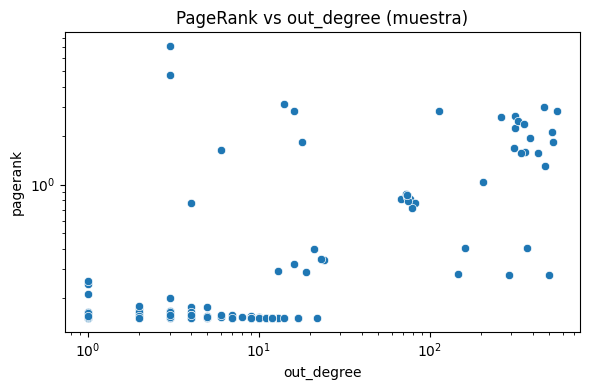

In [106]:
#PageRank vs degree: ¿nodos “bien conectados a hubs”?
deg_pr = (
    pr_df
      .select("pagerank", "in_degree", "out_degree")
      .sample(False, 0.001, seed=42)   # muestreo para no matar la RAM
)

deg_pr_pd = deg_pr.toPandas()

# luego, por ejemplo (en otra celda):
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.scatterplot(
    data=deg_pr_pd,
    x="out_degree",
    y="pagerank"
)
plt.xscale("log")
plt.yscale("log")
plt.title("PageRank vs out_degree (muestra)")
plt.tight_layout()


In [107]:
# PageRank / eigenvector dentro de comunidades “calientes”
community_pr = (
    pr_df
      .groupBy("louvain_id")
      .agg(
          F.mean("pagerank").alias("mean_pagerank"),
          F.mean("eigenvector").alias("mean_eigenvector"),
          F.mean("fraud_out_ratio").alias("mean_fraud_out_ratio"),
          F.mean("fraud_in_ratio").alias("mean_fraud_in_ratio"),
          F.count("*").alias("num_nodes")
      )
)

# Por ejemplo, ordenar por comunidades más "fraudulentas"
community_pr_hot = (
    community_pr
      .orderBy(F.desc("mean_fraud_out_ratio"))
)

community_pr_pd = community_pr_hot.limit(50).toPandas()
community_pr_pd.head()


/home/felpipe/1 - UDD/Bank fraud detection/KaggleChallenges/venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
                                                                                

,louvain_id,mean_pagerank,mean_eigenvector,mean_fraud_out_ratio,mean_fraud_in_ratio,num_nodes
0,135898,0.367527,0.000304,0.048128,0.062937,11
1,178494,0.256105,0.000304,0.042793,0.071970,12
2,75851,0.405871,0.000304,0.038462,0.006250,20
3,22796,0.246696,0.000304,0.034161,0.035427,23
4,628646,0.404312,0.000304,0.033445,0.021368,26


In [109]:
#Zoom local: ego-networks de top PageRank (NetworkX)
# Suponiendo que tienes el account_number de un nodo con PR alto
target_acct = int(topk_pr["account_number"].iloc[0])

ego_query = """
MATCH (a:Account {account_number: $acct})- [r:TX] - (b:Account)
RETURN
  a.account_number AS src,
  b.account_number AS dst,
  r.amount         AS amount,
  r.is_laundering  AS is_laundering
"""

rows = graph.run(ego_query, acct=target_acct).data()

import networkx as nx

G_ego = nx.DiGraph()
for row in rows:
    G_ego.add_edge(row["src"], row["dst"],
                   amount=row["amount"],
                   is_laundering=row["is_laundering"])

# Luego puedes contar aristas fraudulentas, motivos, etc.


In [ ]:
#Snapshot temporal de PageRank
query = """
CALL gds.graph.project.cypher(
  'aml_dir_t1',
  'MATCH (a:Account) RETURN id(a) AS id',
  'MATCH (a:Account)-[r:TX]->(b:Account)
   WHERE r.tx_datetime >= $t_start
     AND r.tx_datetime <  $t_end
   RETURN id(a) AS source, id(b) AS target, r.amount AS amount',
  { parameters: { t_start: datetime($t_start), t_end: datetime($t_end) } }
)
YIELD graphName, nodeCount, relationshipCount
RETURN graphName, nodeCount, relationshipCount
"""

df = graph.run(
    query,
    t_start="2019-01-01T00:00:00",
    t_end="2019-01-31T00:00:00",
).to_data_frame()

In [112]:
df

,graphName,nodeCount,relationshipCount
0,aml_dir_t1,855460,0


In [114]:
a = graph.run("MATCH (a:Account) RETURN a LIMIT 1").data()
a[0]['a']

Node('Account', account_number=4651102136, closeness=4.8121181347579025e-05, current_balance=51445.619999999995, eigenvector=7.295954489629177e-05, first_seen=DateTime(2023, 3, 18, 0, 35, 31.0), kcore=12, last_seen=DateTime(2023, 3, 18, 21, 45, 28.0), location='UK', louvain_id=418931, pagerank=0.16042123768253225, scc_id=152512, wcc_id=12376, **{'mclose_2023_03_UK pounds': 51445.619999999995})

El PageRank global presenta una distribución con una base bastante compacta y una cola muy pronunciada:

- la mediana está alrededor de 0.172,
- la mayoría de los nodos se concentra entre ~0.15 y ~0.3,
- pero el percentil 99 ya está por encima de 2.2, y el percentil 99.9 supera 3.6, con un máximo en torno a 12.9. 

Esto indica que:

- casi todo el “peso de importancia” se concentra en un grupo muy pequeño de cuentas;
- el resto tiene un PageRank sólo ligeramente por encima del valor base, reflejando un rol poco central en el flujo de dinero.

En el top de nodos por PageRank, se observa un conjunto compacto de cuentas con valores muy cercanos entre sí, lo que suele corresponder a un tipo de núcleo denso de la red (cuentas que se enlazan mutuamente o que participan en patrones recurrentes de tránsito de fondos). 

Comparado con el eigenvector centrality, PageRank es más sensible a la direccionalidad del flujo (quién recibe de quién), por lo que resulta especialmente útil como feature a nivel nodo en un problema de clasificación de cuentas (y también para inducir priors de importancia para las aristas salientes).

## Clustering coefficient

Clustering coefficient (coeficiente de agrupamiento)

Mide cuántos triángulos (amigos de mis amigos) hay alrededor de un nodo.

AML:

- Células de layering a veces forman pequeños cliques o motivos muy cerrados.
- Un nodo con clustering muy alto dentro de una comunidad pequeña y caliente → candidato claro a actividad coordinada.

In [ ]:
#Promedio global de clústering del grafo
graph.run("""
CALL gds.localClusteringCoefficient.stats('aml_wcc', {
  concurrency: 4
})
//YIELD averageClusteringCoefficient, nodeCount, preProcessingMillis, computeMillis, postProcessingMillis
//RETURN
//  nodeCount,
//  averageClusteringCoefficient,
//  preProcessingMillis + computeMillis + postProcessingMillis AS totalMillis;
""")
#Intentar correr en browser

In [ ]:
#Escribir el coeficiente de clústering a los nodos
graph.run("""
CALL gds.localClusteringCoefficient.write('aml_wcc', {
  writeProperty: 'lcc',
  concurrency: 4
})
//YIELD
//  averageClusteringCoefficient,
//  nodeCount,
//  nodePropertiesWritten,
//  preProcessingMillis,
//  computeMillis,
//  postProcessingMillis,
//  writeMillis
//RETURN
//  nodeCount,
//  nodePropertiesWritten,
//  averageClusteringCoefficient,
//  preProcessingMillis + computeMillis + postProcessingMillis + writeMillis AS totalMillis;
""")
#Intentar correr en browser

In [115]:
clust_nodes_query = """
MATCH (a:Account)
WHERE a.lcc IS NOT NULL
RETURN
  a.account_number AS account_number,
  a.lcc            AS lcc
"""

df_lcc = (
    spark.read
         .format("org.neo4j.spark.DataSource")
         .options(**opts)                              # mismo dict opts que ya tienes
         .option("query", clust_nodes_query)
         .load()
)

df_lcc.cache()
df_lcc.printSchema()
df_lcc.limit(10).toPandas()


root
 |-- account_number: long (nullable = true)
 |-- lcc: double (nullable = true)



/home/felpipe/1 - UDD/Bank fraud detection/KaggleChallenges/venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
                                                                                

,account_number,lcc
0,4651102136,0.0
1,3647155427,0.0
2,8986636663,0.0
3,196361780,0.0
4,3775525103,0.0
5,6961445449,0.0
6,8515001526,0.0
7,5082164096,0.0
8,723890129,0.0
9,7156880781,0.0


No se observan patrones tipo triángulo A→B→C→A

## Edge betweenness centrality

Edge betweenness centrality

Lo mismo que betweenness, pero a nivel de aristas.

AML:
- Detecta relaciones-canal: pares de cuentas por donde pasa mucho flujo de caminos cortos entre comunidades.
- Pueden ser relaciones banco–cliente muy críticas, o enlaces clave entre células.

In [ ]:
#Debido a costos computacionales, caducidad de aristas, y riquezas de las features anteriores no se procede a calcular edge betweenness centrality en este caso

# Motifs y patrones AML clásicos

Dado que es AML, te interesan patrones como:

Cadenas: A → B → C → D

Fan-in: muchos emisores → 1 receptor

Fan-out: 1 emisor → muchos receptores

Ciclos: A → B → C → A (o con cambios de moneda).

In [ ]:
# Ejemplo: ventana 2020-01-01 a 2020-01-31 -> sirve para reducir la carga de cómputo, o en el caso de trabajo con snapshots
t_start = "2020-01-01"
t_end   = "2020-02-01"

edges_win = (
    edges_df
    .filter(
        (F.col("timestamp") >= F.to_timestamp(F.lit(t_start))) &
        (F.col("timestamp") <  F.to_timestamp(F.lit(t_end)))
    )
    .cache()
)

edges_win.count()  # sanity check


Cuando se mira el clustering coefficient a nivel nodo y se examinan ejemplos, prácticamente no aparecen triángulos del tipo A→B→C→A: el coeficiente local para los nodos muestreados es 0.0 y se deja explícito que “no se observan patrones tipo triángulo A→B→C→A”.

Esto cuadra con:

- una topología mayormente acíclica y “árbol-like” en el micro-nivel,
- la idea de que los motifs relevantes en este dataset son más bien cadenas y ciclos cortos simples (round-trips) que cliques densas.

En términos prácticos:

- las métricas basadas en triángulos (clustering alto, cliques) parecen menos informativas aquí,
- mientras que cadenas, round-trips y split–merge sí muestran variabilidad y estructuras interesantes.

## Fan-in: muchos emisores → 1 receptor

In [118]:
fanin = (
    edges_df
    .groupBy("dst")
    .agg(
        F.count("*").alias("n_in_edges"),
        F.countDistinct("src").alias("n_senders"),
        F.sum("amount").alias("total_in_amount"),
        F.sum("is_laundering").alias("n_fraud_in_edges")
    )
    .withColumn(
        "fraud_in_ratio",
        F.col("n_fraud_in_edges") / F.col("n_in_edges")
    )
)

# Hubs de fan-in "importantes"
min_senders = 10  # ajusta según distribución
fanin_hubs = (
    fanin
    .filter(F.col("n_senders") >= min_senders)
    .orderBy(F.col("n_senders").desc())
)


/home/felpipe/1 - UDD/Bank fraud detection/KaggleChallenges/venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
                                                                                

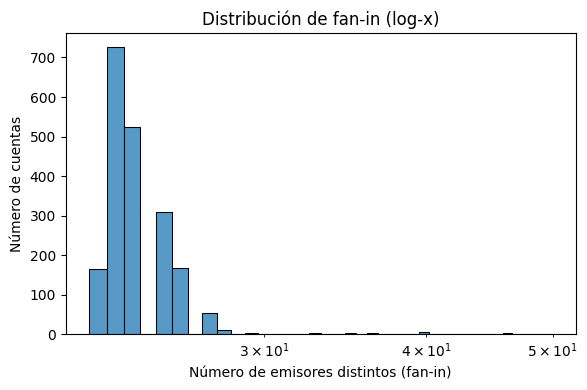

In [119]:
import seaborn as sns
import matplotlib.pyplot as plt

top_fanin_pd = fanin_hubs.limit(2000).toPandas()

plt.figure(figsize=(6,4))
sns.histplot(top_fanin_pd["n_senders"], bins=40)
plt.xscale("log")
plt.xlabel("Número de emisores distintos (fan-in)")
plt.ylabel("Número de cuentas")
plt.title("Distribución de fan-in (log-x)")
plt.tight_layout()


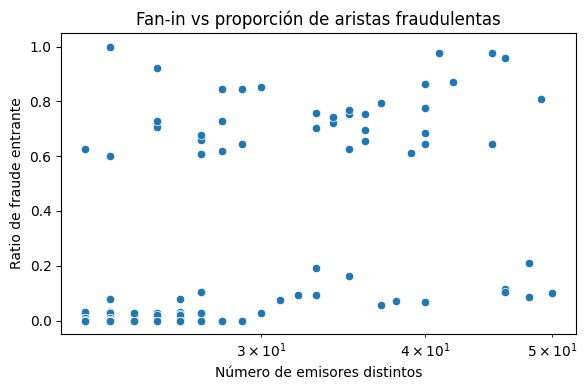

In [121]:
#Vínculo con fraude
plt.figure(figsize=(6,4))
sns.scatterplot(
    data=top_fanin_pd,
    x="n_senders",
    y="fraud_in_ratio"
)
plt.xscale("log")
plt.xlabel("Número de emisores distintos")
plt.ylabel("Ratio de fraude entrante")
plt.title("Fan-in vs proporción de aristas fraudulentas")
plt.tight_layout()


Para fan-in se agrupan las transacciones por receptor (dst) y se calculan, entre otras cosas: número total de aristas entrantes (n_in_edges), número de emisores distintos (n_senders), monto total recibido (total_in_amount) y número de aristas entrantes etiquetadas como lavado (n_fraud_in_edges), a partir de lo cual se define un fraud_in_ratio por cuenta.

Al mirar la distribución de n_senders (histograma en log-x), se ve una estructura fuertemente sesgada:

- Muchísimas cuentas reciben dinero desde muy pocos emisores distintos (1–2, o apenas unas pocas unidades).
- A medida que crece el número de emisores, la frecuencia cae rápido, con una cola larga de receptores que concentran decenas o cientos de contrapartes.
- Es sobre esa cola derecha donde tiene sentido hablar de hubs de fan-in (fanin_hubs), filtrando por un umbral mínimo de emisores (min_senders).

Combinado con los resultados de grados y ratios de fraude globales, la imagen es coherente: la mayoría de las cuentas tienen ratios de fraude bajísimos, pero existen colas que llegan a 1, lo que implica que hay nodos completamente asociados a transacciones fraudulentas. 

Desde la óptica AML, los patrones de fan-in se pueden interpretar así:

- Fan-in alto con fraude bajo: cuentas que actúan como receptores “normales” (comercios, nóminas, proveedores grandes) donde el fraude es residual frente al volumen legítimo.
- Fan-in moderado/alto con fraud_in_ratio elevado: candidatos a cuentas mula o concentradoras de capital ilícito, donde una fracción apreciable de las entradas proviene de aristas ya marcadas como lavado.
- Fan-in bajo con fraud_in_ratio ≈ 1: relaciones muy específicas (pocas fuentes) pero casi siempre fraudulentas; pueden corresponder a pares muy focalizados dentro de una estructura mayor.

Como features, de esta parte salen cosas naturales a nivel nodo:

- n_senders, n_in_edges, total_in_amount,
- n_fraud_in_edges y fraud_in_ratio,
- flags tipo “es hub de fan-in” (por encima de cierto umbral de emisores).

Estos indicadores capturan bien la idea de “cuentas que absorben dinero desde muchos lados” y permiten distinguir entre receptores masivos legítimos y receptores masivos con alta contaminación de fraude.

## Fan-out: 1 emisor → muchos receptores

In [122]:
fanout = (
    edges_df
    .groupBy("src")
    .agg(
        F.count("*").alias("n_out_edges"),
        F.countDistinct("dst").alias("n_receivers"),
        F.sum("amount").alias("total_out_amount"),
        F.sum("is_laundering").alias("n_fraud_out_edges")
    )
    .withColumn(
        "fraud_out_ratio",
        F.col("n_fraud_out_edges") / F.col("n_out_edges")
    )
)

min_receivers = 10
fanout_hubs = (
    fanout
    .filter(F.col("n_receivers") >= min_receivers)
    .orderBy(F.col("n_receivers").desc())
)


/home/felpipe/1 - UDD/Bank fraud detection/KaggleChallenges/venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
                                                                                

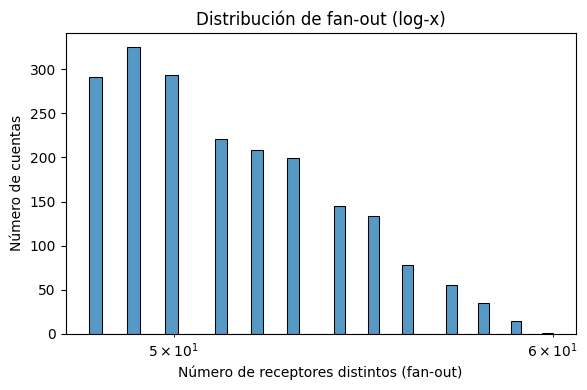

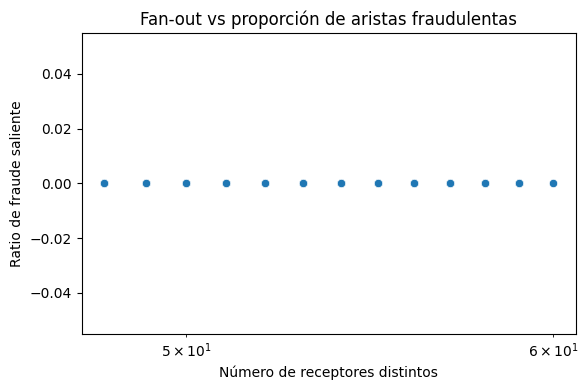

In [123]:
top_fanout_pd = fanout_hubs.limit(2000).toPandas()

plt.figure(figsize=(6,4))
sns.histplot(top_fanout_pd["n_receivers"], bins=40)
plt.xscale("log")
plt.xlabel("Número de receptores distintos (fan-out)")
plt.ylabel("Número de cuentas")
plt.title("Distribución de fan-out (log-x)")
plt.tight_layout()

plt.figure(figsize=(6,4))
sns.scatterplot(
    data=top_fanout_pd,
    x="n_receivers",
    y="fraud_out_ratio"
)
plt.xscale("log")
plt.xlabel("Número de receptores distintos")
plt.ylabel("Ratio de fraude saliente")
plt.title("Fan-out vs proporción de aristas fraudulentas")
plt.tight_layout()


Simétricamente, para fan-out se agrupa por emisor (src) y se calculan: número de aristas salientes (n_out_edges), número de receptores distintos (n_receivers), monto total enviado (total_out_amount), número de aristas salientes fraudulentas (n_fraud_out_edges) y el fraud_out_ratio correspondiente.

La distribución de n_receivers (de nuevo en log-x) muestra el patrón clásico de red transaccional:

- La mayoría de las cuentas activas envían dinero a muy pocos receptores (1–2, hasta un puñado de destinos distintos).
- Sólo una fracción pequeña de nodos presenta fan-out alto, con decenas o más receptores distintos: son los verdaderos hubs emisores.
- Sobre esos hubs (fanout_hubs) es donde se explora la relación entre diversificación de receptores (n_receivers) y fraud_out_ratio.

El scatter n_receivers vs. fraud_out_ratio no sugiere una relación monótona simple, sino varios “regímenes”:

- Muchas cuentas con fan-out bajo y fraud_out_ratio cercano a 0: clientes minoristas que hacen pocas transferencias, casi todas legítimas.
- Un subconjunto de nodos con fan-out medio/alto pero con ratios de fraude aún bajos: podrían ser nodos operativos (pagadores de nómina, proveedores, etc.) que dispersan fondos a muchos destinos pero sin señal fuerte de lavado.
- Un grupo más pequeño donde fan-out y fraud_out_ratio son ambos apreciables: emisores que reparten dinero entre muchos receptores y, además, una parte importante de sus salidas está etiquetada como fraude. Estos son consistentes con patrones de layering por dispersión.

Conectando esto con el análisis bivariado de grado vs. montos, se refuerza la idea de que hay dos grandes perfiles de cuentas: (i) muchas transacciones con montos medios moderados y (ii) pocas transacciones con montos medios gigantes.
Cuando ese segundo patrón coincide con fan-out alto y fraud_out_ratio elevado, el perfil es muy compatible con nodos dedicados a “rebotar” grandes montos hacia múltiples cuentas de destino.

Como features nodales útiles de fan-out:

- n_receivers, n_out_edges, total_out_amount,
- n_fraud_out_edges y fraud_out_ratio,
- un flag “hub de fan-out” según umbral de receptores.

## Cadenas A→B→C (largo 2) y A→B→C→D (largo 3)

In [124]:
e1 = edges_df.select(
    F.col("src").alias("A"),
    F.col("dst").alias("B"),
    F.col("timestamp").alias("t1"),
    F.col("amount").alias("amount1"),
    F.col("is_laundering").alias("is_l1")
)

e2 = edges_df.select(
    F.col("src").alias("B"),
    F.col("dst").alias("C"),
    F.col("timestamp").alias("t2"),
    F.col("amount").alias("amount2"),
    F.col("is_laundering").alias("is_l2")
)

chains2 = (
    e1.join(e2, "B")
      .filter(F.col("t1") <= F.col("t2"))
      .withColumn(
          "has_fraud",
          (F.col("is_l1") + F.col("is_l2") > 0)
      )
      .withColumn(
          "total_amount",
          F.col("amount1") + F.col("amount2")
      )
      .select("A", "B", "C", "has_fraud", "total_amount")
)


In [125]:
#Agregando por nodo para que sea manejable
chains2_by_A = (
    chains2
    .groupBy("A")
    .agg(
        F.count("*").alias("n_chains2"),
        F.sum(F.col("has_fraud").cast("int")).alias("n_fraud_chains2"),
        F.sum("total_amount").alias("sum_amount_chains2")
    )
    .withColumn(
        "fraud_chain2_ratio",
        F.col("n_fraud_chains2") / F.col("n_chains2")
    )
)


In [126]:
# Opcional: subventana más corta
sub_start = "2020-01-01"
sub_end   = "2020-01-08"

# edges_sub = (
#     edges_win
#     .filter(
#         (F.col("timestamp") >= F.to_timestamp(F.lit(sub_start))) &
#         (F.col("timestamp") <  F.to_timestamp(F.lit(sub_end)))
#     )
# )

e1 = edges_df.select(
    F.col("src").alias("A"),
    F.col("dst").alias("B"),
    F.col("timestamp").alias("t1"),
    F.col("amount").alias("amount1"),
    F.col("is_laundering").alias("is_l1")
)

e2 = edges_df.select(
    F.col("src").alias("B"),
    F.col("dst").alias("C"),
    F.col("timestamp").alias("t2"),
    F.col("amount").alias("amount2"),
    F.col("is_laundering").alias("is_l2")
)

e3 = edges_df.select(
    F.col("src").alias("C"),
    F.col("dst").alias("D"),
    F.col("timestamp").alias("t3"),
    F.col("amount").alias("amount3"),
    F.col("is_laundering").alias("is_l3")
)

chains3 = (
    e1.join(e2, "B")
      .join(e3, "C")
      .filter((F.col("t1") <= F.col("t2")) & (F.col("t2") <= F.col("t3")))
      # evitar repeticiones obvias de nodo
      .filter((F.col("A") != F.col("C")) & (F.col("A") != F.col("D")))
      .withColumn(
          "has_fraud",
          (F.col("is_l1") + F.col("is_l2") + F.col("is_l3") > 0)
      )
      .withColumn(
          "total_amount",
          F.col("amount1") + F.col("amount2") + F.col("amount3")
      )
      .select("A", "B", "C", "D", "has_fraud", "total_amount")
)

chains3_by_A = (
    chains3
    .groupBy("A")
    .agg(
        F.count("*").alias("n_chains3"),
        F.sum(F.col("has_fraud").cast("int")).alias("n_fraud_chains3"),
        F.sum("total_amount").alias("sum_amount_chains3")
    )
    .withColumn(
        "fraud_chain3_ratio",
        F.col("n_fraud_chains3") / F.col("n_chains3")
    )
)


/home/felpipe/1 - UDD/Bank fraud detection/KaggleChallenges/venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
                                                                                

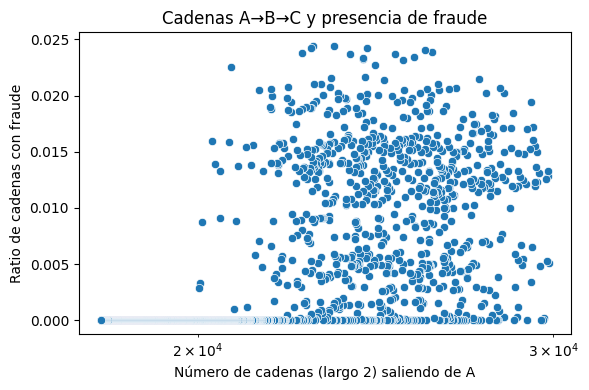

In [127]:
chains2_pd = (
    chains2_by_A
    .orderBy(F.col("n_chains2").desc())
    .limit(2000)
    .toPandas()
)

plt.figure(figsize=(6,4))
sns.scatterplot(
    data=chains2_pd,
    x="n_chains2",
    y="fraud_chain2_ratio"
)
plt.xscale("log")
plt.xlabel("Número de cadenas (largo 2) saliendo de A")
plt.ylabel("Ratio de cadenas con fraude")
plt.title("Cadenas A→B→C y presencia de fraude")
plt.tight_layout()


En las cadenas de largo 2 y 3 se construyen todos los paths posibles A→B→C y A→B→C→D dentro de una ventana de tiempo, y luego se agregan por cuenta de origen A: número de cadenas, cuántas tocan al menos una arista fraudulenta y el monto total que fluye por ellas.

La nube de puntos 
n\_chains2
n_chains2 vs. 
fraud\_chain2\_ratio
fraud_chain2_ratio (y análogo para cadenas de largo 3) muestra:

- Muchísimas cuentas con pocas cadenas y ratio de fraude 0: la inmensa mayoría de los emisores genera trayectorias “lineales” sin etiquetas de lavado.
- Una cola de cuentas con muchas cadenas salientes (ordenes de magnitud más que la media) pero con ratios de fraude que no necesariamente son extremos: algunos grandes emisores parecen operar sobre todo en patrones normales.
- Un subconjunto de cuentas con ratios de fraude altos (cercanos a 1) incluso con un número moderado de cadenas: estas son especialmente interesantes porque una fracción muy grande de sus trayectorias cortas está contaminada por aristas fraudulentas, a pesar de que su grado o volumen no sean extremos.

Desde el punto de vista AML, esto cuadra con dos perfiles:

- Cuentas operativas “normales”: muchas cadenas, pero con baja proporción de pasos etiquetados como fraude.
- Cuentas “carrier” de fraude: no necesariamente hiperconectadas, pero casi todo lo que hacen se inserta en trayectorias con lavado.

Como feature, tiene sentido conservar para cada nodo cosas como:

- número de cadenas 2/3 donde aparece como origen,
- proporción de esas cadenas que tocan al menos una arista fraudulenta,
- monto total canalizado a través de esas cadenas.

## Ciclos simples / round-trip A↔B

In [128]:
e1 = edges_df.select(
    F.col("src").alias("A"),
    F.col("dst").alias("B"),
    F.col("timestamp").alias("t1"),
    F.col("amount").alias("amount1"),
    F.col("payment_currency").alias("cur1"),
    F.col("is_laundering").alias("is_l1")
)

e2 = edges_df.select(
    F.col("src").alias("B"),
    F.col("dst").alias("A"),
    F.col("timestamp").alias("t2"),
    F.col("amount").alias("amount2"),
    F.col("payment_currency").alias("cur2"),
    F.col("is_laundering").alias("is_l2")
)

max_hours = 48  # round-trip en menos de 2 días, por ejemplo

round_trips = (
    e1.join(e2, ["A", "B"])  # misma pareja A-B
      .filter(F.col("t1") <= F.col("t2"))
      .withColumn(
          "time_diff_hours",
          (F.col("t2").cast("long") - F.col("t1").cast("long")) / 3600.0
      )
      .filter(F.col("time_diff_hours") <= max_hours)
      .withColumn(
          "has_fraud",
          (F.col("is_l1") + F.col("is_l2") > 0)
      )
      .withColumn(
          "total_amount",
          F.col("amount1") + F.col("amount2")
      )
      .withColumn(
          "currency_switch",
          (F.col("cur1") != F.col("cur2"))
      )
      .select("A", "B", "time_diff_hours", "total_amount",
              "has_fraud", "currency_switch")
)


In [129]:
#Agregado por pareja
round_trips_pair = (
    round_trips
    .groupBy("A", "B")
    .agg(
        F.count("*").alias("n_round_trips"),
        F.sum(F.col("has_fraud").cast("int")).alias("n_fraud_round_trips"),
        F.sum(F.col("currency_switch").cast("int")).alias("n_fx_round_trips"),
        F.sum("total_amount").alias("sum_amount_round_trips")
    )
    .withColumn(
        "fraud_round_trip_ratio",
        F.col("n_fraud_round_trips") / F.col("n_round_trips")
    )
)

rt_pd = (
    round_trips_pair
    .orderBy(F.col("n_round_trips").desc())
    .limit(1000)
    .toPandas()
)


/home/felpipe/1 - UDD/Bank fraud detection/KaggleChallenges/venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
                                                                                

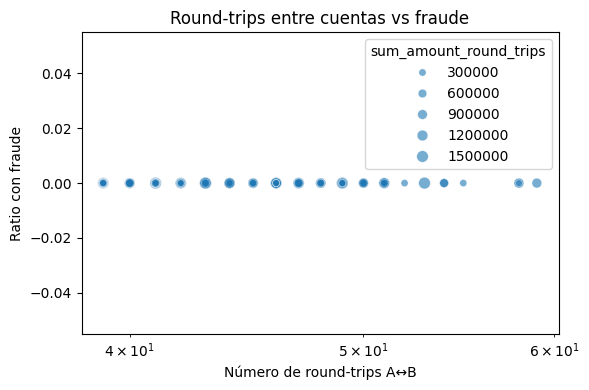

In [130]:
plt.figure(figsize=(6,4))
sns.scatterplot(
    data=rt_pd,
    x="n_round_trips",
    y="fraud_round_trip_ratio",
    size="sum_amount_round_trips",
    alpha=0.6
)
plt.xscale("log")
plt.xlabel("Número de round-trips A↔B")
plt.ylabel("Ratio con fraude")
plt.title("Round-trips entre cuentas vs fraude")
plt.tight_layout()


Los round-trips capturan ciclos de longitud 2 del tipo A→B→A en una ventana corta, agregados por par (A,B): cuántos ciclos hay, cuántos incluyen fraude y cuánto monto total circula en ida y vuelta.

En el scatter de 
n\_round\_trips
n_round_trips vs. 
fraud\_round\_trip\_ratio
fraud_round_trip_ratio (escala log en el eje X, tamaño proporcional al monto total) se ve:

- Una gran masa de pares con muy pocos round-trips y ratio 0: transferencias esporádicas de ida y vuelta cliente–comercio, cliente–banco, etc.
- Algunos pares con pocos round-trips pero ratio 1: cada vez que se forma un ciclo entre esas dos cuentas, aparece al menos una arista marcada como lavado. Suelen ser puntos con tamaño de burbuja más pequeño (monto total moderado), pero muy “puros” en fraude.
- Un puñado de pares con muchos round-trips (parte derecha de la nube) donde el ratio de fraude no llega siempre a 1, pero tampoco es cercano a 0: hay relaciones muy recurridas, con volumen alto, que mezclan transacciones legítimas y sospechosas.

Interpretación AML:

- Los pares con muchos round-trips y monto grande pueden corresponder a relaciones comerciales intensas o “canales” de movimiento de fondos.
- Los pares con pocos round-trips pero ratio cercano a 1 parecen más bien micro-estructuras de blanqueo, donde las pocas veces que el dinero entra en modo “ping-pong” es para algo turbio.
- Juntos, estos motivos son buenos candidatos para features a nivel arista/par de cuentas (por ejemplo: “número de round-trips”, “ratio de round-trips con fraude”, “monto max/min en round-trips”).

## Split merge (A reparte → intermedios → D concentra)

In [7]:
#Paths A→M→D en ventana corta
e1 = edges_df.select(
    F.col("src").alias("A"),
    F.col("dst").alias("M"),
    F.col("timestamp").alias("t1"),
    F.col("amount").alias("amount1"),
    F.col("is_laundering").alias("is_l1")
)

e2 = edges_df.select(
    F.col("src").alias("M"),
    F.col("dst").alias("D"),
    F.col("timestamp").alias("t2"),
    F.col("amount").alias("amount2"),
    F.col("is_laundering").alias("is_l2")
)

max_hours = 48

paths_AMD = (
    e1.join(e2, "M")
      .filter(F.col("t1") <= F.col("t2"))
      .withColumn(
          "time_diff_hours",
          (F.col("t2").cast("long") - F.col("t1").cast("long")) / 3600.0
      )
      .filter(F.col("time_diff_hours") <= max_hours)
      .withColumn(
          "is_fraud_path",
          (F.col("is_l1") + F.col("is_l2") > 0)
      )
      .withColumn(
          "path_amount",
          F.col("amount1") + F.col("amount2")
      )
      .select("A", "M", "D", "is_fraud_path", "path_amount")
)


In [8]:
#Agregar por par (A, D): verdadero motif split–merge
min_middle = 3  # al menos 3 cuentas intermedias distintas

split_merge = (
    paths_AMD
    .groupBy("A", "D")
    .agg(
        F.countDistinct("M").alias("n_middle_accounts"),
        F.count("*").alias("n_paths"),
        F.sum(F.col("is_fraud_path").cast("int")).alias("n_fraud_paths"),
        F.sum("path_amount").alias("total_amount")
    )
    .filter(F.col("n_middle_accounts") >= min_middle)
)

sm_pd = (
    split_merge
    .orderBy(F.col("n_middle_accounts").desc(), F.col("n_paths").desc())
    .limit(1000)
    .toPandas()
)


/home/felpipe/1 - UDD/Bank fraud detection/KaggleChallenges/venv/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:111: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  PyArrow >= 4.0.0 must be installed; however, it was not found.
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
                                                                                

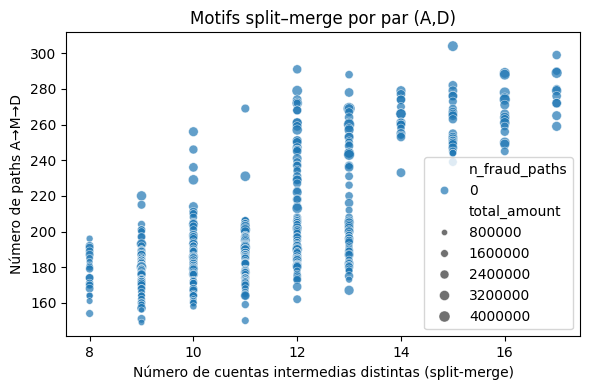

In [13]:
plt.figure(figsize=(6,4))
sns.scatterplot(
    data=sm_pd,
    x="n_middle_accounts",
    y="n_paths",
    size="total_amount",
    hue="n_fraud_paths",
    alpha=0.7
)
plt.xlabel("Número de cuentas intermedias distintas (split-merge)")
plt.ylabel("Número de paths A→M→D")
plt.title("Motifs split–merge por par (A,D)")
plt.tight_layout()


Aquí se buscan patrones del tipo:

A → M₁, M₂, …, Mₖ → D

en una ventana temporal corta, midiendo para cada par (A,D): cuántas cuentas intermedias distintas hay, cuántos paths A→M→D existen, si esos paths tocan fraude y el monto total canalizado.

En el scatter 
n\_middle\_accounts
n_middle_accounts (eje X) vs. 
n\_paths
n_paths (eje Y), con el tamaño de punto proporcional al monto total y el color a 
n\_fraud\_paths
n_fraud_paths, se observa:

- La mayoría de los pares (A,D) tiene pocos intermediarios y pocos paths: split–merge “débiles”, compatibles con un cliente que paga a un conjunto pequeño de terceros que luego pagan a un proveedor común.
- Un subconjunto pequeño de (A,D) presenta muchos intermediarios (k ≥ 3, 5, 10) y un número alto de paths A→M→D: verdaderos motivos de dispersión y re-agregación.
- Entre estos motivos fuertes:
  - algunos tienen monto total muy alto pero casi sin paths marcados como fraude (podrían ser macro-estructuras normales del generador sintético, p.ej. payroll/tesorería),
  - otros muestran un número apreciable de paths fraudulentos, a veces sobre una base de paths relativamente pequeña: cada vez que A “pasa por la malla” de intermediarios hacia D, es probable que haya lavado.

Desde la óptica AML, los motivos split–merge donde:

- el número de intermediarios es grande,
- el ratio n\_fraud\_paths / n\_paths n_fraud_paths/n_paths es alto, y
- el monto agregado es significativo,

son exactamente el tipo de patrón que se busca cuando se habla de layering: dispersar montos grandes en muchos tickets pequeños y luego volver a concentrarlos.

Como features resultan interesantes:

- a nivel (A,D): número de intermediarios, paths totales, paths con fraude, monto total,
- a nivel nodo: cuántos motivos split–merge “fuertes” tiene como origen o destino.

## Juntando todo

Cadenas cortas identifican cuentas cuyas trayectorias típicas tocan fraude con alta probabilidad, incluso si sus grados o montos no son extremos.

Round-trips señalan pares de cuentas con relaciones bidireccionales sospechosas, distinguiendo entre canales muy usados y micro-patrones casi siempre fraudulentos.

Los motivos de split–merge capturan justo el comportamiento de dispersar y reconcentrar fondos a través de muchos intermediarios, con un subconjunto claro de (A,D) que se comporta como estructuras de layering.

Sobre esa estructura, los patrones de fan-in y fan-out añaden una capa de “tipología nodal”:

- fan-in alto identifica cuentas que concentran flujos desde muchos emisores (desde hubs operativos hasta posibles cuentas mula según su ratio de fraude),
- fan-out alto identifica cuentas que dispersan fondos hacia muchos receptores (desde pagadores legítimos hasta nodos de layering por dispersión),
y la intersección de ambos (nodos con fan-in y fan-out elevados y alta contaminación de fraude) apunta a cuentas estructuralmente centrales en los esquemas de lavado.

Además, los resultados de SCC y comunidades mostraban que los ciclos no triviales, las subredes calientes de fraude y estos motivos locales se concentran en grupos relativamente pequeños pero bien definidos.

Todo esto encaja: el grafo AML no está lleno de patrones exóticos por todas partes, pero sí hay un conjunto reducido de nodos y pares de nodos que concentran motifs “AML-like” (cadenas, round-trips, split–merge, fan-in/fan-out anómalos) y que son candidatos naturales para:

- features estructurales en modelos (tanto para clasificación de aristas como, luego, de cuentas),
- seeds para búsqueda de subgrafos sospechosos y para reglas del tipo “si un nodo participa en X motivos de este tipo, elevar score de riesgo”.

# Querys en Cypher para preparar GDS en saml-d

Esta parte se sale del EDA, está como respaldo de códigos debido que en algunas ocasiones fue necesario trabajar directamente en el browser. Aquí se presentan ordenadas para documentación.

In [ ]:
// Ver qué grafos hay ahora mismo (probablemente ninguno)
CALL gds.graph.list();

In [ ]:
// Proyección no dirigida para WCC, Louvain, k-core, betweenness, closeness
CALL gds.graph.project(
  'aml_wcc',
  'Account',
  {
    TX: {
      type: 'TX',
      orientation: 'UNDIRECTED'
    }
  }
);


In [ ]:
CALL gds.graph.list('aml_wcc')
YIELD graphName, nodeCount, relationshipCount
RETURN graphName, nodeCount, relationshipCount;


In [ ]:
CALL gds.louvain.write(
  'aml_wcc',
  {
    writeProperty: 'louvain_id'
  }
)
YIELD communityCount, modularity
RETURN communityCount, modularity;


In [ ]:
CALL gds.kcore.write(
  'aml_wcc',
  {
    writeProperty: 'kcore',
    concurrency: 4
  }
)
YIELD nodePropertiesWritten, degeneracy
RETURN nodePropertiesWritten, degeneracy;


In [ ]:
CALL gds.betweenness.stats(
  'aml_wcc',
  {
    samplingSize: 20000,
    concurrency: 4
  }
)
YIELD centralityDistribution, computeMillis, configuration
RETURN centralityDistribution, computeMillis, configuration.samplingSize AS samplingSize;


In [ ]:
CALL gds.closeness.write(
  'aml_wcc',
  {
    writeProperty: 'closeness',
    concurrency: 4,
    useWassermanFaust: true
  }
)
YIELD nodePropertiesWritten, centralityDistribution, computeMillis, writeMillis
RETURN nodePropertiesWritten, centralityDistribution, computeMillis, writeMillis;


In [ ]:
CALL gds.graph.project(
  'aml_scc',
  'Account',
  'TX'    // orientación NATURAL por defecto
);


In [ ]:
CALL gds.graph.list('aml_scc')
YIELD graphName, nodeCount, relationshipCount
RETURN graphName, nodeCount, relationshipCount;


In [ ]:
CALL gds.scc.write(
  'aml_scc',
  {
    writeProperty: 'scc_id'
  }
)
YIELD componentCount, componentDistribution, computeMillis, writeMillis
RETURN componentCount, componentDistribution, computeMillis, writeMillis;


In [ ]:
CALL gds.pageRank.write(
  'aml_scc',
  {
    maxIterations: 20,
    dampingFactor: 0.85,
    writeProperty: 'pagerank',
    concurrency: 4
  }
)
YIELD nodePropertiesWritten, computeMillis, writeMillis
RETURN nodePropertiesWritten, computeMillis, writeMillis;


In [ ]:
CALL gds.graph.project(
  'aml_eig_und',
  'Account',
  {
    TX: {
      type: 'TX',
      orientation: 'UNDIRECTED',
      properties: {
        amount: {
          property: 'amount',
          defaultValue: 0.0
        }
      }
    }
  }
);


In [ ]:
CALL gds.eigenvector.write(
  'aml_eig_und',
  {
    maxIterations: 50,
    tolerance: 1e-6,
    relationshipWeightProperty: 'amount',
    writeProperty: 'eigenvector',
    concurrency: 4
  }
)
YIELD nodePropertiesWritten, computeMillis, writeMillis
RETURN nodePropertiesWritten, computeMillis, writeMillis;


In [ ]:
CALL gds.graph.list()
YIELD graphName, nodeCount, relationshipCount
RETURN graphName, nodeCount, relationshipCount
ORDER BY graphName;
